In [1]:
!pwd
import sys

/c/Users/81908/jupyter_notebook/tf_2_work/Probspace_geme_compe/notebook


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sys.executable

'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# 対戦ゲームデータ分析甲子園
- https://prob.space/competitions/game_winner/data/62

In [3]:
import os
import gc
import sys
import joblib
import warnings
import itertools
import pathlib
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
from lightgbm import *

sys.path.append(r"C:\Users\81908\Git\xfeat")
import xfeat
from xfeat import *
from xfeat.selector import *
from xfeat.utils import compress_df

sns.set()
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_columns", 300)

In [4]:
OUT_MODEL = (
    r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train"
)
os.makedirs(OUT_MODEL, exist_ok=True)

DATA_DIR = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\data\feature_eng"

ORIG = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\data\orig"
train_df = pd.read_csv(f"{ORIG}/train_data.csv")
test_df = pd.read_csv(f"{ORIG}/test_data.csv")
df_all = train_df.append(test_df).reset_index(drop=True)
display(df_all.head(3))

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,game-ver,id,lobby,lobby-mode,mode,period,stage,y
0,139,NaN,sshooter_becchu,118.0,NaN,soytuber_custom,13.0,NaN,pablo_hue,10.0,NaN,hokusai,28,NaN,bold_7,26.0,NaN,hokusai_becchu,68.0,NaN,herocharger_replica,31.0,NaN,sharp_neo,5.0.1,1,standard,regular,nawabari,2019-10-15T20:00:00+00:00,sumeshi,1.0
1,198,NaN,parashelter_sorella,77.0,NaN,jetsweeper,198.0,NaN,campingshelter_camo,123.0,NaN,nzap85,83,NaN,momiji,118.0,NaN,squiclean_b,168.0,NaN,campingshelter,151.0,NaN,sputtery_clear,5.0.1,2,standard,regular,nawabari,2019-12-14T04:00:00+00:00,arowana,0.0
2,114,a-,nzap89,68.0,a,quadhopper_black,225.0,a,prime_becchu,107.0,a,jetsweeper,50,a-,bold_7,163.0,a+,nzap85,160.0,a-,prime_becchu,126.0,a,dualsweeper_custom,5.0.1,3,standard,gachi,hoko,2019-12-25T14:00:00+00:00,ama,0.0


# モデル作成

In [5]:
def count_encoder(train_df, valid_df, cat_features=None):
    """
    Count_Encoding: カテゴリ列をカウント値に変換する特徴量エンジニアリング（要はgroupby().size()の集計列追加のこと）
    ※カウント数が同じカテゴリは同じようなデータ傾向になる可能性がある
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    # conda install -c conda-forge category_encoders
    import category_encoders as ce

    if cat_features is None:
        cat_features = train_df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.to_list()

    count_enc = ce.CountEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    count_enc.fit(train_df[cat_features])
    train_encoded = train_df.join(
        count_enc.transform(train_df[cat_features]).add_suffix("_count")
    )
    valid_encoded = valid_df.join(
        count_enc.transform(valid_df[cat_features]).add_suffix("_count")
    )

    return train_encoded, valid_encoded


def target_encoder(train_df, valid_df, target_col: str, cat_features=None):
    """
    Target_Encoding: カテゴリ列を目的変数の平均値に変換する特徴量エンジニアリング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    # conda install -c conda-forge category_encoders
    import category_encoders as ce

    if cat_features is None:
        cat_features = train_df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.to_list()

    target_enc = ce.TargetEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    target_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        target_enc.transform(train_df[cat_features]).add_suffix("_target")
    )
    valid_encoded = valid_df.join(
        target_enc.transform(valid_df[cat_features]).add_suffix("_target")
    )
    return train_encoded, valid_encoded


def catboost_encoder(train_df, valid_df, target_col: str, cat_features=None):
    """
    CatBoost_Encoding: カテゴリ列を目的変数の1行前の行からのみに変換する特徴量エンジニアリング
    CatBoost使ったターゲットエンコーディング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    # conda install -c conda-forge category_encoders
    import category_encoders as ce

    if cat_features is None:
        cat_features = train_df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.to_list()

    cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

    # trainだけでfitすること(validationやtest含めるとリークする)
    cb_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        cb_enc.transform(train_df[cat_features]).add_suffix("_cb")
    )
    valid_encoded = valid_df.join(
        cb_enc.transform(valid_df[cat_features]).add_suffix("_cb")
    )
    return train_encoded, valid_encoded

In [6]:
class Model:
    def __init__(self, OUTPUT_DIR, dict_enc_flag={"count": True, "target": True, "catboost": True}):
        self.OUTPUT_DIR = OUTPUT_DIR
        self.dict_enc_flag = dict_enc_flag

    # LightGBM GBDT with KFold or Stratified KFold
    # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
    def kfold_cv_LGBMClassifier(
        self,
        lgb_params: dict,
        df: pd.DataFrame,
        num_folds: int,
        target_col: str,
        del_cols=None,
        select_cols=None,
        eval_metric="error",
        stratified=True,  # StratifiedKFoldにするか
        is_submission=False,  # Home_Credit_Default_Risk の submission.csv作成するか
        is_plot_perm_importance=False,  # permutation importanceも出すか. feature_importance はデフォルトでだす
    ):
        """
        LGBMClassifierでcross validation + feature_importance/permutation importance plot
        """
        # Divide in training/validation and test data
        train_df = df[df[target_col].notnull()].reset_index(drop=True)
        test_df = df[df[target_col].isnull()].reset_index(drop=True)
        print(
            "Starting LightGBM. Train shape: {}, test shape: {}".format(
                train_df.shape, test_df.shape
            )
        )
        del df
        gc.collect()

        # Cross validation model
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

        # Create arrays and dataframes to store results
        oof_preds = np.zeros(train_df.shape[0])
        sub_preds = np.zeros(test_df.shape[0])
        feature_importance_df = pd.DataFrame()
        permutation_importance_df = pd.DataFrame()
        result_scores = {}
        train_probas = {}
        test_probas = {}

        # 目的変数とID列など削除
        del_cols = del_cols.append(target_col) if del_cols is not None else [target_col]
        feats = [f for f in train_df.columns if f not in del_cols]

        for n_fold, (train_idx, valid_idx) in tqdm(
            enumerate(folds.split(train_df[feats], train_df[target_col]))
        ):
            t_fold_df = train_df.iloc[train_idx]
            v_fold_df = train_df.iloc[valid_idx]

            if self.dict_enc_flag["count"]:
                # カウントエンコディング
                t_fold_df, v_fold_df = count_encoder(
                    t_fold_df, v_fold_df, cat_features=None
                )
            if self.dict_enc_flag["target"]:
                # ターゲットエンコディング
                t_fold_df, v_fold_df = target_encoder(
                    t_fold_df, v_fold_df, target_col=target_col, cat_features=None
                )
            if self.dict_enc_flag["catboost"]:
                # CatBoostエンコディング
                t_fold_df, v_fold_df = catboost_encoder(
                    t_fold_df, v_fold_df, target_col=target_col, cat_features=None
                )
            # ラベルエンコディング
            cate_cols = t_fold_df.select_dtypes(
                include=["object", "category", "bool"]
            ).columns.to_list()
            for col in cate_cols:
                t_fold_df[col], uni = pd.factorize(t_fold_df[col])
                v_fold_df[col], uni = pd.factorize(v_fold_df[col])
            print(
                "run encoding Train shape: {}, valid shape: {}".format(
                    t_fold_df.shape, v_fold_df.shape
                )
            )
            # 指定の列あればそれだけにする
            feats = t_fold_df.columns.to_list() if select_cols is None else select_cols
            if target_col in feats:
                feats.remove(target_col)
            print("len(feats):", len(feats))

            train_x, train_y = (
                t_fold_df[feats],
                t_fold_df[target_col],
            )
            valid_x, valid_y = (
                v_fold_df[feats],
                v_fold_df[target_col],
            )

            ############################ train fit ############################
            # LightGBM parameters found by Bayesian optimization
            clf = LGBMClassifier(**lgb_params)
            clf.fit(
                train_x,
                train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric=eval_metric,
                verbose=200,
                early_stopping_rounds=200,
            )

            # モデル保存
            joblib.dump(clf, f"{self.OUTPUT_DIR}/lgb-{n_fold + 1}.model", compress=True)

            # valid pred
            oof_preds[valid_idx] = clf.predict_proba(
                valid_x, num_iteration=clf.best_iteration_
            )[:, 1]

            ############################ test pred ############################
            if self.dict_enc_flag["count"]:
                # カウントエンコディング
                tr_df, te_df = count_encoder(train_df, test_df, cat_features=None)
            else:
                tr_df, te_df = train_df, test_df
            if self.dict_enc_flag["target"]:
                # ターゲットエンコディング
                tr_df, te_df = target_encoder(tr_df, te_df, target_col=target_col, cat_features=None)
            else:
                tr_df, te_df = tr_df, te_df
            if self.dict_enc_flag["catboost"]:
                # CatBoostエンコディング
                tr_df, te_df = catboost_encoder(tr_df, te_df, target_col=target_col, cat_features=None)
            else:
                tr_df, te_df = tr_df, te_df
            # ラベルエンコディング
            cate_cols = tr_df.select_dtypes(
                include=["object", "category", "bool"]
            ).columns.to_list()
            for col in cate_cols:
                tr_df[col], uni = pd.factorize(tr_df[col])
                te_df[col], uni = pd.factorize(te_df[col])
                
            # testの確信度
            test_probas[f"fold_{str(n_fold + 1)}"] = clf.predict_proba(
                te_df[feats], num_iteration=clf.best_iteration_
            )[:, 1]
            sub_preds += test_probas[f"fold_{str(n_fold + 1)}"] / folds.n_splits

            # 一応trainの確信度も出しておく
            train_probas[f"fold_{str(n_fold + 1)}"] = clf.predict_proba(
                tr_df[feats], num_iteration=clf.best_iteration_
            )[:, 1]

            if eval_metric == "auc":
                fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
                print("Fold %2d AUC : %.6f" % (n_fold + 1, fold_auc))
                result_scores[f"fold_auc_{str(n_fold + 1)}"] = fold_auc
            elif eval_metric == "error":
                # intにしないとaccuracy_score()エラーになる
                _pred = oof_preds[valid_idx]
                _pred[_pred >= 0.5] = 1
                _pred[_pred < 0.5] = 0
                fold_err = 1.0 - accuracy_score(valid_y, _pred)
                print("Fold %2d error : %.6f" % (n_fold + 1, fold_err))
                result_scores[f"fold_err_{str(n_fold + 1)}"] = fold_err

            # feature_importance
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat(
                [feature_importance_df, fold_importance_df], axis=0
            )

            if is_plot_perm_importance:
                # permutation_importance
                # 時間かかるからifで制御する
                # scoringはsklearnのスコアリングパラメータ
                # accuracy や neg_mean_squared_log_error とか
                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                fold_importance_df = pd.DataFrame()
                fold_permutation = permutation_importance(
                    clf, valid_x, valid_y, scoring="roc_auc"
                )
                fold_permutation_df = pd.DataFrame(
                    {
                        "feature": valid_x.columns,
                        "importance": np.abs(
                            fold_permutation["importances_mean"]
                        ),  # マイナスとるのもあるので絶対値にする
                        "fold": n_fold + 1,
                    },
                )
                permutation_importance_df = pd.concat(
                    [permutation_importance_df, fold_permutation_df], axis=0
                )

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        if eval_metric == "auc":
            mean_fold_auc = roc_auc_score(train_df[target_col], oof_preds)
            print("Full AUC score %.6f" % mean_fold_auc)
            result_scores["mean_fold_auc"] = mean_fold_auc
        elif eval_metric == "error":
            # intにしないとaccuracy_score()エラーになる
            _pred = oof_preds
            _pred[_pred >= 0.5] = 1
            _pred[_pred < 0.5] = 0
            mean_fold_err = 1.0 - accuracy_score(train_df[target_col], _pred)
            print("Full error score %.6f" % mean_fold_err)
            result_scores["mean_fold_err"] = mean_fold_err

        # モデルのスコア出力
        result_scores_df = pd.DataFrame(
            result_scores.values(), index=result_scores.keys()
        )
        result_scores_df.to_csv(f"{self.OUTPUT_DIR}/result_scores.tsv", sep="\t")

        test_probas_df = pd.DataFrame(test_probas)
        test_probas_df.to_csv(f"{self.OUTPUT_DIR}/test_probas.tsv", index=False)
        train_probas_df = pd.DataFrame(train_probas)
        train_probas_df.to_csv(f"{self.OUTPUT_DIR}/train_probas.tsv", index=False)

        # Write submission file (Home_Credit_Default_Risk)
        if is_submission:
            sub_preds[sub_preds >= 0.5] = 1
            sub_preds[sub_preds < 0.5] = 0
            test_df[target_col] = sub_preds
            submission_file_name = f"{self.OUTPUT_DIR}/submission_kernel.csv"
            sub_df = test_df[[target_col]]
            sub_df["id"] = test_df.index
            sub_df.astype(int)
            sub_df = sub_df[["id", "y"]]
            sub_df.to_csv(submission_file_name, index=False)

        # Plot feature importance
        Model("").display_importances(
            feature_importance_df,
            png_path=f"{self.OUTPUT_DIR}/lgbm_feature_importances.png",
            title="feature_importance",
        )
        if is_plot_perm_importance:
            Model("").display_importances(
                permutation_importance_df,
                png_path=f"{self.OUTPUT_DIR}/lgbm_permutation_importances.png",
                title="permutation_importance",
            )

        return feature_importance_df, permutation_importance_df

    # Display/plot feature/permutation importance
    @staticmethod
    def display_importances(
        importance_df_, png_path, title,
    ):
        cols = (
            importance_df_[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:40]
            .index
        )
        best_features = importance_df_.loc[importance_df_.feature.isin(cols)]
        plt.figure(figsize=(8, 10))
        sns.barplot(
            x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False),
        )
        plt.title(f"LightGBM {title} (avg over folds)")
        plt.tight_layout()
        plt.savefig(png_path)

In [9]:
def base_train(df, dict_enc_flag={"count": True, "target": True, "catboost": True}, out_dir=OUT_MODEL):
    is_debug = False
    # is_debug = True
    if is_debug:
        _df = df.head(1000)
        _df = _df.append(df.tail(100))
        df = _df

    best_params = {'subsample': 0.9, 'subsample_freq': 6, 'colsample_bytree': 0.1, 'max_depth': 7, 'min_child_samples': 343, 'min_child_weight': 0.04084861948055769, 'num_leaves': 95, 'reg_alpha': 0.5612212694825488, 'reg_lambda': 0.0001757886119766502}
        
    os.makedirs(out_dir, exist_ok=True)
    model = Model(out_dir, dict_enc_flag)
    lgb_params = dict(
        n_estimators=10000,
        learning_rate=0.01,
        silent=-1,
        #verbose=-1,
        # verbose=1,
        importance_type="gain",
        random_state=71,
        **best_params,
    )
    params = dict(
        lgb_params=lgb_params,
        df=df,
        #num_folds=10,
        num_folds=4,
        target_col="y",
        del_cols=None,
        eval_metric="error",
        #stratified=True,
        stratified=False,
        is_submission=True,
        is_plot_perm_importance=False,
    )
    feat_importance, perm_importance = model.kfold_cv_LGBMClassifier(**params)

# preprocess.csv
## target encoding系の列あるほうがいいか確認
- count + catboost が一番良さそう

In [34]:
df_all = pd.read_csv(f"{DATA_DIR}/preprocess.csv", index_col=0)

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


run encoding Train shape: (49578, 35), valid shape: (16527, 35)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.457824	training's binary_logloss: 0.68506	valid_1's binary_error: 0.472015	valid_1's binary_logloss: 0.69004
[400]	training's binary_error: 0.414135	training's binary_logloss: 0.679422	valid_1's binary_error: 0.474012	valid_1's binary_logloss: 0.689432
Early stopping, best iteration is:
[235]	training's binary_error: 0.449695	training's binary_logloss: 0.68413	valid_1's binary_error: 0.4702	valid_1's binary_logloss: 0.689927
Fold  1 error : 0.470200


1it [00:01,  1.52s/it]

run encoding Train shape: (49579, 35), valid shape: (16526, 35)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.46205	training's binary_logloss: 0.684816	valid_1's binary_error: 0.477066	valid_1's binary_logloss: 0.689843
[400]	training's binary_error: 0.415741	training's binary_logloss: 0.679105	valid_1's binary_error: 0.4692	valid_1's binary_logloss: 0.688611
[600]	training's binary_error: 0.392101	training's binary_logloss: 0.674044	valid_1's binary_error: 0.466961	valid_1's binary_logloss: 0.687888
[800]	training's binary_error: 0.375603	training's binary_logloss: 0.669466	valid_1's binary_error: 0.465388	valid_1's binary_logloss: 0.687394
[1000]	training's binary_error: 0.365477	training's binary_logloss: 0.665292	valid_1's binary_error: 0.464299	valid_1's binary_logloss: 0.687121
[1200]	training's binary_error: 0.357651	training's binary_logloss: 0.661457	valid_1's binary_error: 0.461334	valid_1's binary_logloss: 0.68688
Early stoppi

2it [00:05,  2.25s/it]

run encoding Train shape: (49579, 35), valid shape: (16526, 35)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.458037	training's binary_logloss: 0.684879	valid_1's binary_error: 0.472891	valid_1's binary_logloss: 0.68937
[400]	training's binary_error: 0.410295	training's binary_logloss: 0.679067	valid_1's binary_error: 0.467808	valid_1's binary_logloss: 0.68807
[600]	training's binary_error: 0.387059	training's binary_logloss: 0.674012	valid_1's binary_error: 0.464238	valid_1's binary_logloss: 0.687124
[800]	training's binary_error: 0.372295	training's binary_logloss: 0.669495	valid_1's binary_error: 0.463028	valid_1's binary_logloss: 0.686521
[1000]	training's binary_error: 0.361645	training's binary_logloss: 0.665441	valid_1's binary_error: 0.459821	valid_1's binary_logloss: 0.686097
Early stopping, best iteration is:
[954]	training's binary_error: 0.364005	training's binary_logloss: 0.666379	valid_1's binary_error: 0.458732	valid_1's b

3it [00:08,  2.60s/it]

run encoding Train shape: (49579, 35), valid shape: (16526, 35)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.463987	training's binary_logloss: 0.684842	valid_1's binary_error: 0.479003	valid_1's binary_logloss: 0.689755
[400]	training's binary_error: 0.417273	training's binary_logloss: 0.679257	valid_1's binary_error: 0.469926	valid_1's binary_logloss: 0.688124
[600]	training's binary_error: 0.392263	training's binary_logloss: 0.674296	valid_1's binary_error: 0.461394	valid_1's binary_logloss: 0.686961
[800]	training's binary_error: 0.375179	training's binary_logloss: 0.66995	valid_1's binary_error: 0.457219	valid_1's binary_logloss: 0.686233
[1000]	training's binary_error: 0.364792	training's binary_logloss: 0.665948	valid_1's binary_error: 0.456493	valid_1's binary_logloss: 0.68568
[1200]	training's binary_error: 0.356522	training's binary_logloss: 0.662228	valid_1's binary_error: 0.453165	valid_1's binary_logloss: 0.68511
[1400]	trai

4it [00:13,  3.46s/it]


Full error score 0.459769


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


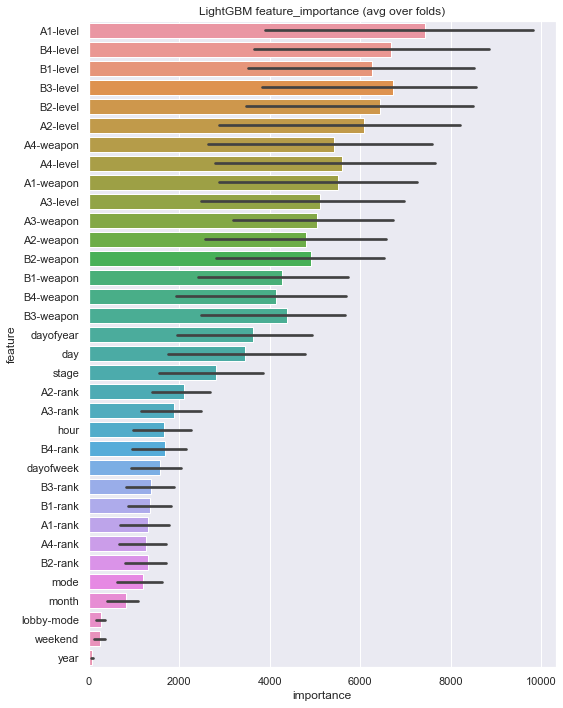

In [21]:
base_train(df_all, dict_enc_flag={"count": False, "target": False, "catboost": False})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 54), valid shape: (16527, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.443947	training's binary_logloss: 0.683229	valid_1's binary_error: 0.470019	valid_1's binary_logloss: 0.689233
[400]	training's binary_error: 0.396749	training's binary_logloss: 0.67635	valid_1's binary_error: 0.463787	valid_1's binary_logloss: 0.688053
[600]	training's binary_error: 0.373936	training's binary_logloss: 0.670483	valid_1's binary_error: 0.464513	valid_1's binary_logloss: 0.687492
Early stopping, best iteration is:
[407]	training's binary_error: 0.395074	training's binary_logloss: 0.67611	valid_1's binary_error: 0.463302	valid_1's binary_logloss: 0.688032
Fold  1 error : 0.463302


1it [00:03,  3.06s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.447246	training's binary_logloss: 0.682879	valid_1's binary_error: 0.475493	valid_1's binary_logloss: 0.689814
[400]	training's binary_error: 0.396115	training's binary_logloss: 0.675611	valid_1's binary_error: 0.468655	valid_1's binary_logloss: 0.688553
[600]	training's binary_error: 0.371448	training's binary_logloss: 0.669523	valid_1's binary_error: 0.466417	valid_1's binary_logloss: 0.687977
[800]	training's binary_error: 0.356461	training's binary_logloss: 0.663831	valid_1's binary_error: 0.463996	valid_1's binary_logloss: 0.687673
Early stopping, best iteration is:
[678]	training's binary_error: 0.364408	training's binary_logloss: 0.667323	valid_1's binary_error: 0.463331	valid_1's binary_logloss: 0.687866
Fold  2 error : 0.463331


2it [00:06,  3.31s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.441961	training's binary_logloss: 0.682813	valid_1's binary_error: 0.471439	valid_1's binary_logloss: 0.689219
[400]	training's binary_error: 0.390548	training's binary_logloss: 0.675543	valid_1's binary_error: 0.463936	valid_1's binary_logloss: 0.688032
[600]	training's binary_error: 0.368704	training's binary_logloss: 0.669399	valid_1's binary_error: 0.460668	valid_1's binary_logloss: 0.687358
[800]	training's binary_error: 0.352508	training's binary_logloss: 0.663859	valid_1's binary_error: 0.458913	valid_1's binary_logloss: 0.686822
[1000]	training's binary_error: 0.340426	training's binary_logloss: 0.658593	valid_1's binary_error: 0.461092	valid_1's binary_logloss: 0.686572
Early stopping, best iteration is:
[883]	training's binary_error: 0.347264	training's binary_logloss: 0.661576	valid_1's binary_error: 0.4574	valid_1's b

3it [00:11,  3.70s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.450211	training's binary_logloss: 0.68266	valid_1's binary_error: 0.477187	valid_1's binary_logloss: 0.689776
[400]	training's binary_error: 0.399806	training's binary_logloss: 0.675927	valid_1's binary_error: 0.471136	valid_1's binary_logloss: 0.688205
[600]	training's binary_error: 0.373767	training's binary_logloss: 0.669992	valid_1's binary_error: 0.463452	valid_1's binary_logloss: 0.687231
[800]	training's binary_error: 0.356119	training's binary_logloss: 0.664561	valid_1's binary_error: 0.460668	valid_1's binary_logloss: 0.686576
[1000]	training's binary_error: 0.344864	training's binary_logloss: 0.659445	valid_1's binary_error: 0.461394	valid_1's binary_logloss: 0.686036
Early stopping, best iteration is:
[868]	training's binary_error: 0.352427	training's binary_logloss: 0.662825	valid_1's binary_error: 0.459458	valid_1's 

4it [00:16,  4.02s/it]


Full error score 0.460873


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


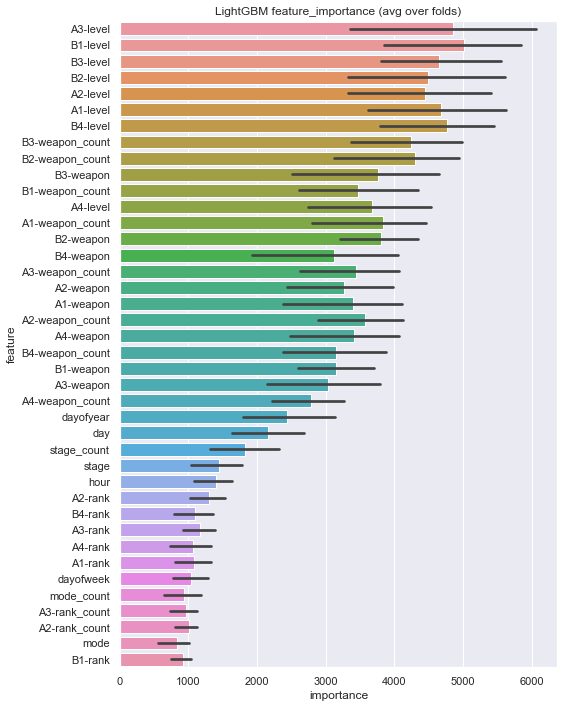

In [25]:
base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": False})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 54), valid shape: (16527, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.412865	training's binary_logloss: 0.679133	valid_1's binary_error: 0.461366	valid_1's binary_logloss: 0.687992
[400]	training's binary_error: 0.378494	training's binary_logloss: 0.669338	valid_1's binary_error: 0.453924	valid_1's binary_logloss: 0.686145
[600]	training's binary_error: 0.364517	training's binary_logloss: 0.661603	valid_1's binary_error: 0.451746	valid_1's binary_logloss: 0.685455
[800]	training's binary_error: 0.354936	training's binary_logloss: 0.654982	valid_1's binary_error: 0.452895	valid_1's binary_logloss: 0.685028
Early stopping, best iteration is:
[682]	training's binary_error: 0.360099	training's binary_logloss: 0.658725	valid_1's binary_error: 0.450475	valid_1's binary_logloss: 0.685339
Fold  1 error : 0.450475


1it [00:04,  4.80s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.413966	training's binary_logloss: 0.678506	valid_1's binary_error: 0.466961	valid_1's binary_logloss: 0.688603
[400]	training's binary_error: 0.37653	training's binary_logloss: 0.668269	valid_1's binary_error: 0.463936	valid_1's binary_logloss: 0.687325
[600]	training's binary_error: 0.360858	training's binary_logloss: 0.660245	valid_1's binary_error: 0.466538	valid_1's binary_logloss: 0.686988
Early stopping, best iteration is:
[424]	training's binary_error: 0.373263	training's binary_logloss: 0.667085	valid_1's binary_error: 0.461515	valid_1's binary_logloss: 0.687251
Fold  2 error : 0.461515


2it [00:08,  4.55s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.411646	training's binary_logloss: 0.678741	valid_1's binary_error: 0.465569	valid_1's binary_logloss: 0.688186
[400]	training's binary_error: 0.376248	training's binary_logloss: 0.668653	valid_1's binary_error: 0.464541	valid_1's binary_logloss: 0.686627
[600]	training's binary_error: 0.363985	training's binary_logloss: 0.660664	valid_1's binary_error: 0.462181	valid_1's binary_logloss: 0.686054
[800]	training's binary_error: 0.354182	training's binary_logloss: 0.653654	valid_1's binary_error: 0.462423	valid_1's binary_logloss: 0.685904
Early stopping, best iteration is:
[741]	training's binary_error: 0.356361	training's binary_logloss: 0.655542	valid_1's binary_error: 0.460608	valid_1's binary_logloss: 0.685967
Fold  3 error : 0.460608


3it [00:13,  4.67s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.418423	training's binary_logloss: 0.678878	valid_1's binary_error: 0.470108	valid_1's binary_logloss: 0.688296
[400]	training's binary_error: 0.380282	training's binary_logloss: 0.66927	valid_1's binary_error: 0.458792	valid_1's binary_logloss: 0.686347
[600]	training's binary_error: 0.363541	training's binary_logloss: 0.661535	valid_1's binary_error: 0.458671	valid_1's binary_logloss: 0.685251
[800]	training's binary_error: 0.353214	training's binary_logloss: 0.654851	valid_1's binary_error: 0.457643	valid_1's binary_logloss: 0.684694
[1000]	training's binary_error: 0.345872	training's binary_logloss: 0.648712	valid_1's binary_error: 0.454556	valid_1's binary_logloss: 0.684527
[1200]	training's binary_error: 0.340225	training's binary_logloss: 0.643509	valid_1's binary_error: 0.454677	valid_1's binary_logloss: 0.684604
Early sto

4it [00:19,  4.92s/it]


Full error score 0.456652


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


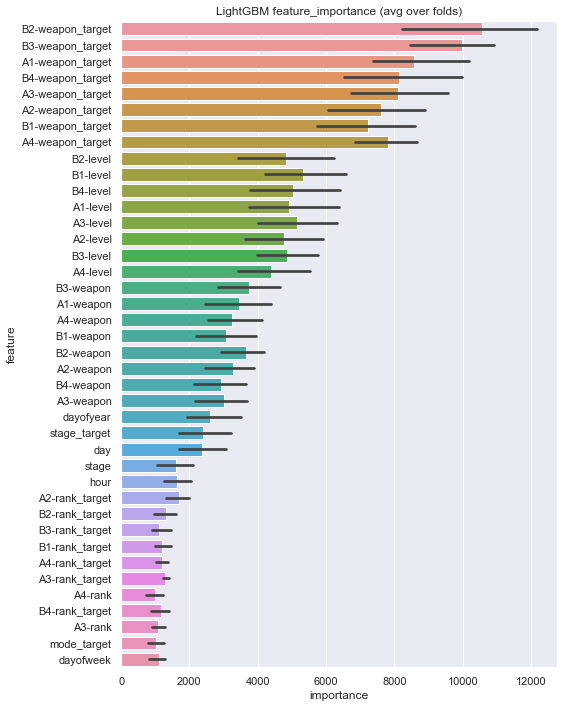

In [28]:
base_train(df_all, dict_enc_flag={"count": False, "target": True, "catboost": False})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 54), valid shape: (16527, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.413086	training's binary_logloss: 0.679122	valid_1's binary_error: 0.460035	valid_1's binary_logloss: 0.687952
[400]	training's binary_error: 0.378858	training's binary_logloss: 0.66933	valid_1's binary_error: 0.453319	valid_1's binary_logloss: 0.68612
[600]	training's binary_error: 0.364456	training's binary_logloss: 0.661595	valid_1's binary_error: 0.452714	valid_1's binary_logloss: 0.685406
[800]	training's binary_error: 0.354613	training's binary_logloss: 0.654934	valid_1's binary_error: 0.453077	valid_1's binary_logloss: 0.684984
Early stopping, best iteration is:
[683]	training's binary_error: 0.36024	training's binary_logloss: 0.658686	valid_1's binary_error: 0.450475	valid_1's binary_logloss: 0.685293
Fold  1 error : 0.450475


1it [00:05,  5.71s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.4133	training's binary_logloss: 0.678504	valid_1's binary_error: 0.467748	valid_1's binary_logloss: 0.688573
[400]	training's binary_error: 0.376329	training's binary_logloss: 0.668242	valid_1's binary_error: 0.463936	valid_1's binary_logloss: 0.687325
[600]	training's binary_error: 0.360455	training's binary_logloss: 0.660196	valid_1's binary_error: 0.463875	valid_1's binary_logloss: 0.686925
Early stopping, best iteration is:
[404]	training's binary_error: 0.375703	training's binary_logloss: 0.668028	valid_1's binary_error: 0.462786	valid_1's binary_logloss: 0.687319
Fold  2 error : 0.462786


2it [00:10,  5.46s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.412796	training's binary_logloss: 0.678774	valid_1's binary_error: 0.466053	valid_1's binary_logloss: 0.688205
[400]	training's binary_error: 0.376026	training's binary_logloss: 0.668705	valid_1's binary_error: 0.464178	valid_1's binary_logloss: 0.686626
Early stopping, best iteration is:
[303]	training's binary_error: 0.389621	training's binary_logloss: 0.673149	valid_1's binary_error: 0.462725	valid_1's binary_logloss: 0.687243
Fold  3 error : 0.462725


3it [00:15,  5.21s/it]

run encoding Train shape: (49579, 54), valid shape: (16526, 54)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.418262	training's binary_logloss: 0.678848	valid_1's binary_error: 0.470531	valid_1's binary_logloss: 0.688336
[400]	training's binary_error: 0.38	training's binary_logloss: 0.669205	valid_1's binary_error: 0.459821	valid_1's binary_logloss: 0.686382
[600]	training's binary_error: 0.363037	training's binary_logloss: 0.661495	valid_1's binary_error: 0.458974	valid_1's binary_logloss: 0.685281
Early stopping, best iteration is:
[490]	training's binary_error: 0.370762	training's binary_logloss: 0.665543	valid_1's binary_error: 0.457582	valid_1's binary_logloss: 0.685751
Fold  4 error : 0.457582


4it [00:20,  5.10s/it]


Full error score 0.458392


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


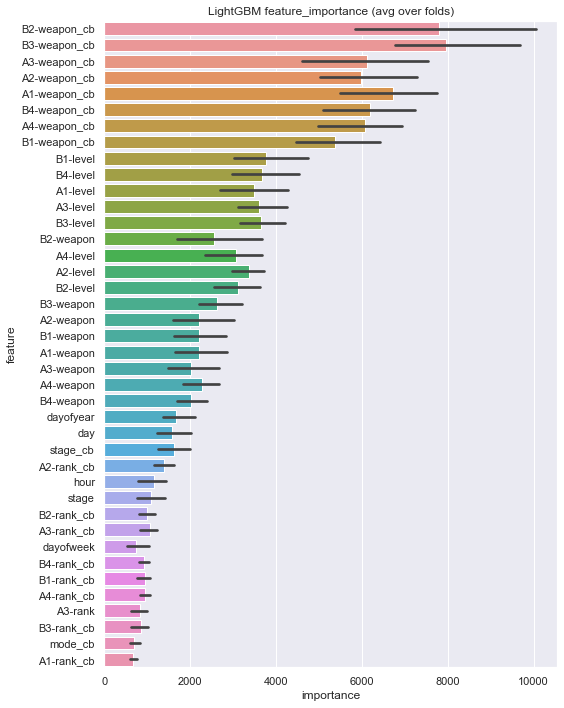

In [29]:
base_train(df_all, dict_enc_flag={"count": False, "target": False, "catboost": True})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 73), valid shape: (16527, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.405059	training's binary_logloss: 0.677492	valid_1's binary_error: 0.459914	valid_1's binary_logloss: 0.687521
[400]	training's binary_error: 0.370628	training's binary_logloss: 0.667135	valid_1's binary_error: 0.453561	valid_1's binary_logloss: 0.685876
[600]	training's binary_error: 0.356267	training's binary_logloss: 0.658166	valid_1's binary_error: 0.450717	valid_1's binary_logloss: 0.685169
Early stopping, best iteration is:
[555]	training's binary_error: 0.359292	training's binary_logloss: 0.65997	valid_1's binary_error: 0.448902	valid_1's binary_logloss: 0.685287
Fold  1 error : 0.448902


1it [00:06,  6.41s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.406785	training's binary_logloss: 0.67714	valid_1's binary_error: 0.466598	valid_1's binary_logloss: 0.688424
[400]	training's binary_error: 0.371226	training's binary_logloss: 0.666616	valid_1's binary_error: 0.465751	valid_1's binary_logloss: 0.686956
[600]	training's binary_error: 0.355836	training's binary_logloss: 0.657391	valid_1's binary_error: 0.46212	valid_1's binary_logloss: 0.686492
[800]	training's binary_error: 0.345973	training's binary_logloss: 0.649989	valid_1's binary_error: 0.457703	valid_1's binary_logloss: 0.686594
Early stopping, best iteration is:
[625]	training's binary_error: 0.354807	training's binary_logloss: 0.656408	valid_1's binary_error: 0.461636	valid_1's binary_logloss: 0.686481
Fold  2 error : 0.461636


2it [00:13,  6.47s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.403558	training's binary_logloss: 0.677326	valid_1's binary_error: 0.46563	valid_1's binary_logloss: 0.687861
[400]	training's binary_error: 0.368543	training's binary_logloss: 0.666742	valid_1's binary_error: 0.46091	valid_1's binary_logloss: 0.686215
[600]	training's binary_error: 0.356381	training's binary_logloss: 0.657423	valid_1's binary_error: 0.459942	valid_1's binary_logloss: 0.685561
[800]	training's binary_error: 0.346437	training's binary_logloss: 0.649851	valid_1's binary_error: 0.458611	valid_1's binary_logloss: 0.685513
Early stopping, best iteration is:
[773]	training's binary_error: 0.347002	training's binary_logloss: 0.650852	valid_1's binary_error: 0.457824	valid_1's binary_logloss: 0.685486
Fold  3 error : 0.457824


3it [00:20,  6.65s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.411505	training's binary_logloss: 0.677531	valid_1's binary_error: 0.4692	valid_1's binary_logloss: 0.688025
[400]	training's binary_error: 0.373263	training's binary_logloss: 0.667325	valid_1's binary_error: 0.457279	valid_1's binary_logloss: 0.68599
[600]	training's binary_error: 0.355473	training's binary_logloss: 0.658397	valid_1's binary_error: 0.455283	valid_1's binary_logloss: 0.684881
[800]	training's binary_error: 0.344743	training's binary_logloss: 0.651278	valid_1's binary_error: 0.455464	valid_1's binary_logloss: 0.684558
Early stopping, best iteration is:
[682]	training's binary_error: 0.351701	training's binary_logloss: 0.65545	valid_1's binary_error: 0.452802	valid_1's binary_logloss: 0.684766
Fold  4 error : 0.452802


4it [00:26,  6.70s/it]


Full error score 0.455291


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


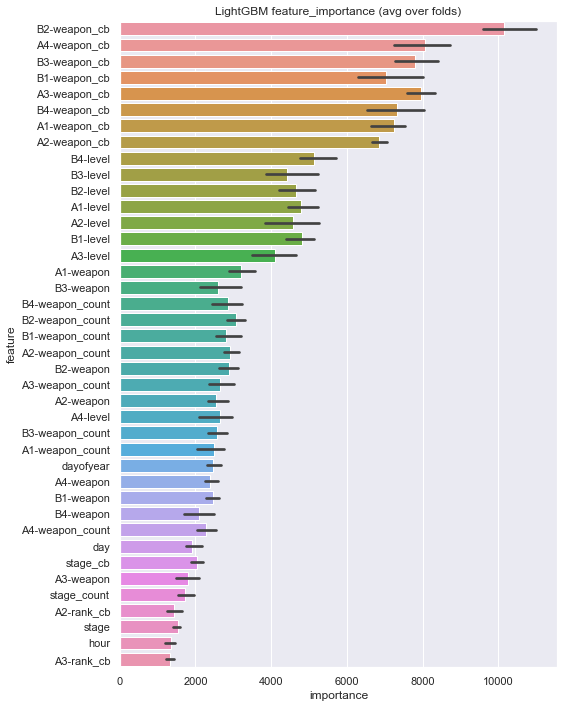

In [30]:
base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": True})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 73), valid shape: (16527, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.404615	training's binary_logloss: 0.677493	valid_1's binary_error: 0.460277	valid_1's binary_logloss: 0.687514
[400]	training's binary_error: 0.370487	training's binary_logloss: 0.667071	valid_1's binary_error: 0.454468	valid_1's binary_logloss: 0.685858
[600]	training's binary_error: 0.356448	training's binary_logloss: 0.658133	valid_1's binary_error: 0.449809	valid_1's binary_logloss: 0.685109
Early stopping, best iteration is:
[567]	training's binary_error: 0.358123	training's binary_logloss: 0.659539	valid_1's binary_error: 0.449386	valid_1's binary_logloss: 0.685178
Fold  1 error : 0.449386


1it [00:05,  5.43s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.406462	training's binary_logloss: 0.677152	valid_1's binary_error: 0.466719	valid_1's binary_logloss: 0.688417
[400]	training's binary_error: 0.371185	training's binary_logloss: 0.666649	valid_1's binary_error: 0.465085	valid_1's binary_logloss: 0.686957
[600]	training's binary_error: 0.355796	training's binary_logloss: 0.657424	valid_1's binary_error: 0.464359	valid_1's binary_logloss: 0.686513
[800]	training's binary_error: 0.345751	training's binary_logloss: 0.650074	valid_1's binary_error: 0.459095	valid_1's binary_logloss: 0.68666
Early stopping, best iteration is:
[625]	training's binary_error: 0.353759	training's binary_logloss: 0.656463	valid_1's binary_error: 0.462362	valid_1's binary_logloss: 0.686495
Fold  2 error : 0.462362


2it [00:11,  5.48s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.403659	training's binary_logloss: 0.677328	valid_1's binary_error: 0.466659	valid_1's binary_logloss: 0.687891
[400]	training's binary_error: 0.368704	training's binary_logloss: 0.666723	valid_1's binary_error: 0.46085	valid_1's binary_logloss: 0.686236
[600]	training's binary_error: 0.356824	training's binary_logloss: 0.657476	valid_1's binary_error: 0.461757	valid_1's binary_logloss: 0.685602
Early stopping, best iteration is:
[465]	training's binary_error: 0.363823	training's binary_logloss: 0.663322	valid_1's binary_error: 0.459942	valid_1's binary_logloss: 0.68595
Fold  3 error : 0.459942


3it [00:16,  5.36s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.411626	training's binary_logloss: 0.67756	valid_1's binary_error: 0.470834	valid_1's binary_logloss: 0.688012
[400]	training's binary_error: 0.373364	training's binary_logloss: 0.667344	valid_1's binary_error: 0.456916	valid_1's binary_logloss: 0.685952
[600]	training's binary_error: 0.356421	training's binary_logloss: 0.658383	valid_1's binary_error: 0.454617	valid_1's binary_logloss: 0.684824
[800]	training's binary_error: 0.345792	training's binary_logloss: 0.651264	valid_1's binary_error: 0.456069	valid_1's binary_logloss: 0.684487
Early stopping, best iteration is:
[605]	training's binary_error: 0.356623	training's binary_logloss: 0.658198	valid_1's binary_error: 0.453588	valid_1's binary_logloss: 0.6848
Fold  4 error : 0.453588


4it [00:21,  5.39s/it]


Full error score 0.456319


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


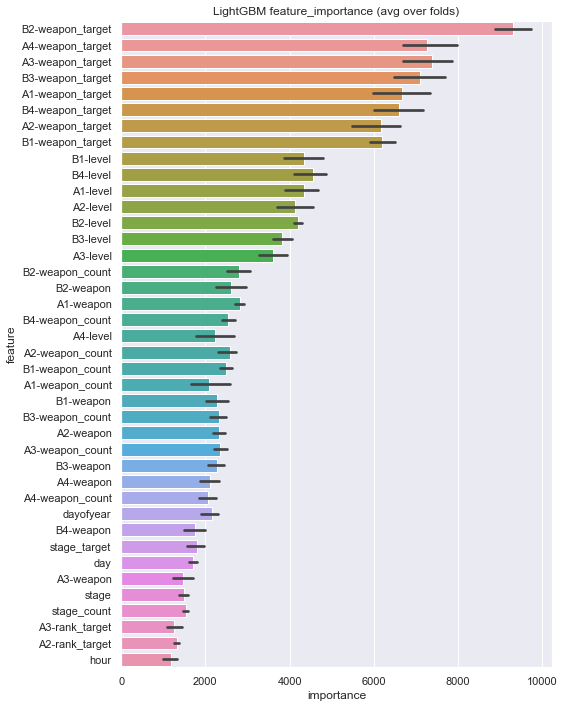

In [32]:
base_train(df_all, dict_enc_flag={"count": True, "target": True, "catboost": False})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 73), valid shape: (16527, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.396628	training's binary_logloss: 0.67484	valid_1's binary_error: 0.455739	valid_1's binary_logloss: 0.68692
[400]	training's binary_error: 0.37557	training's binary_logloss: 0.663856	valid_1's binary_error: 0.451141	valid_1's binary_logloss: 0.685881
Early stopping, best iteration is:
[307]	training's binary_error: 0.383557	training's binary_logloss: 0.668323	valid_1's binary_error: 0.450717	valid_1's binary_logloss: 0.686135
Fold  1 error : 0.450717


1it [00:06,  6.33s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.396942	training's binary_logloss: 0.674289	valid_1's binary_error: 0.466659	valid_1's binary_logloss: 0.688297
[400]	training's binary_error: 0.375865	training's binary_logloss: 0.662984	valid_1's binary_error: 0.464117	valid_1's binary_logloss: 0.687639
Early stopping, best iteration is:
[351]	training's binary_error: 0.378729	training's binary_logloss: 0.665341	valid_1's binary_error: 0.465751	valid_1's binary_logloss: 0.687599
Fold  2 error : 0.465751


2it [00:12,  6.38s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.397164	training's binary_logloss: 0.674695	valid_1's binary_error: 0.466114	valid_1's binary_logloss: 0.687533
Early stopping, best iteration is:
[171]	training's binary_error: 0.40382	training's binary_logloss: 0.676559	valid_1's binary_error: 0.46442	valid_1's binary_logloss: 0.687823
Fold  3 error : 0.464420


3it [00:18,  6.24s/it]

run encoding Train shape: (49579, 73), valid shape: (16526, 73)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.400694	training's binary_logloss: 0.674887	valid_1's binary_error: 0.464178	valid_1's binary_logloss: 0.687609
[400]	training's binary_error: 0.376409	training's binary_logloss: 0.66413	valid_1's binary_error: 0.459155	valid_1's binary_logloss: 0.686161
[600]	training's binary_error: 0.365155	training's binary_logloss: 0.655819	valid_1's binary_error: 0.457703	valid_1's binary_logloss: 0.68589
Early stopping, best iteration is:
[580]	training's binary_error: 0.366365	training's binary_logloss: 0.656609	valid_1's binary_error: 0.457521	valid_1's binary_logloss: 0.685859
Fold  4 error : 0.457521


4it [00:25,  6.50s/it]


Full error score 0.459602


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


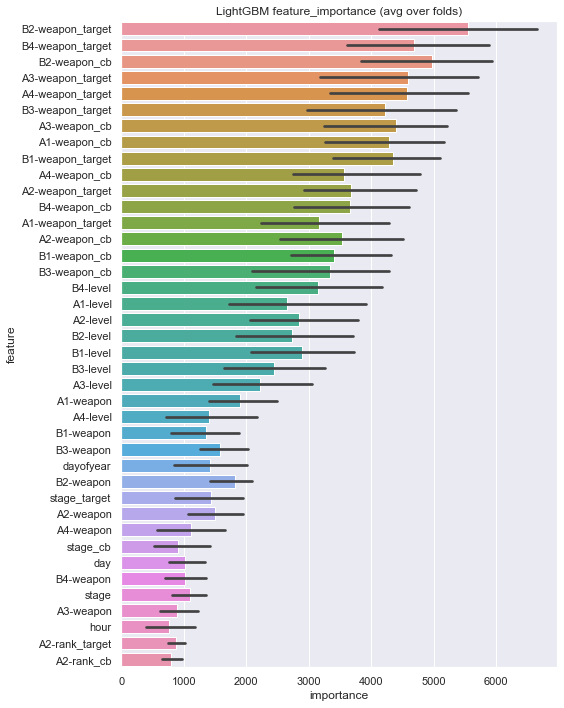

In [31]:
base_train(df_all, dict_enc_flag={"count": False, "target": True, "catboost": True})

Starting LightGBM. Train shape: (66105, 35), test shape: (28340, 35)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 92), valid shape: (16527, 92)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.391827	training's binary_logloss: 0.673782	valid_1's binary_error: 0.452714	valid_1's binary_logloss: 0.68673
Early stopping, best iteration is:
[199]	training's binary_error: 0.391968	training's binary_logloss: 0.673812	valid_1's binary_error: 0.452653	valid_1's binary_logloss: 0.686729
Fold  1 error : 0.452653


1it [00:07,  7.13s/it]

run encoding Train shape: (49579, 92), valid shape: (16526, 92)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.392787	training's binary_logloss: 0.673288	valid_1's binary_error: 0.465388	valid_1's binary_logloss: 0.688006
[400]	training's binary_error: 0.371044	training's binary_logloss: 0.661176	valid_1's binary_error: 0.462604	valid_1's binary_logloss: 0.687524
Early stopping, best iteration is:
[332]	training's binary_error: 0.376087	training's binary_logloss: 0.664865	valid_1's binary_error: 0.463633	valid_1's binary_logloss: 0.687457
Fold  2 error : 0.463633


2it [00:14,  7.28s/it]

run encoding Train shape: (49579, 92), valid shape: (16526, 92)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.392908	training's binary_logloss: 0.673712	valid_1's binary_error: 0.462967	valid_1's binary_logloss: 0.687123
[400]	training's binary_error: 0.371226	training's binary_logloss: 0.66172	valid_1's binary_error: 0.466719	valid_1's binary_logloss: 0.686347
Early stopping, best iteration is:
[211]	training's binary_error: 0.390266	training's binary_logloss: 0.672904	valid_1's binary_error: 0.462604	valid_1's binary_logloss: 0.687024
Fold  3 error : 0.462604


3it [00:21,  7.24s/it]

run encoding Train shape: (49579, 92), valid shape: (16526, 92)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.397104	training's binary_logloss: 0.674097	valid_1's binary_error: 0.462907	valid_1's binary_logloss: 0.687459
[400]	training's binary_error: 0.372355	training's binary_logloss: 0.66276	valid_1's binary_error: 0.460002	valid_1's binary_logloss: 0.686091
Early stopping, best iteration is:
[326]	training's binary_error: 0.37889	training's binary_logloss: 0.666579	valid_1's binary_error: 0.457885	valid_1's binary_logloss: 0.686343
Fold  4 error : 0.457885


4it [00:29,  7.36s/it]


Full error score 0.459194


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


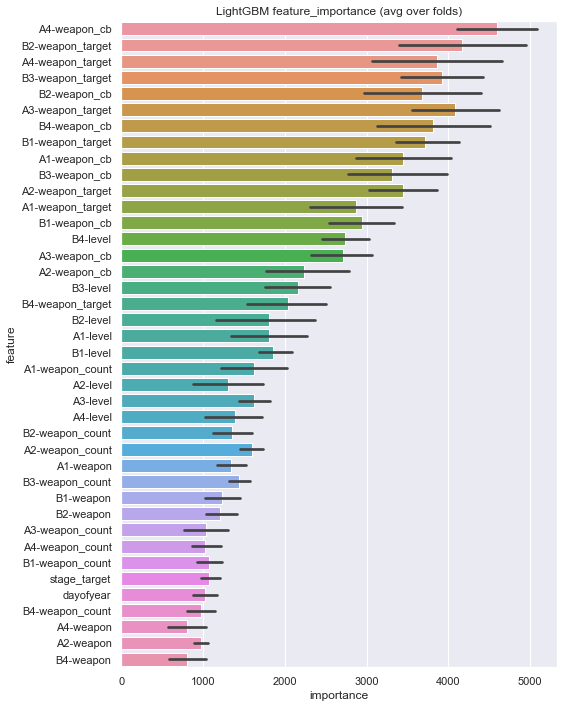

In [33]:
base_train(df_all, dict_enc_flag={"count": True, "target": True, "catboost": True})

## lobby-modeでセグメンテーション
- regularのエラー率よくなる

Starting LightGBM. Train shape: (51669, 34), test shape: (22068, 34)


0it [00:00, ?it/s]

run encoding Train shape: (38751, 70), valid shape: (12918, 70)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.388325	training's binary_logloss: 0.679017	valid_1's binary_error: 0.4695	valid_1's binary_logloss: 0.690175
[400]	training's binary_error: 0.364455	training's binary_logloss: 0.668137	valid_1's binary_error: 0.470197	valid_1's binary_logloss: 0.689758
Early stopping, best iteration is:
[251]	training's binary_error: 0.378597	training's binary_logloss: 0.676042	valid_1's binary_error: 0.466558	valid_1's binary_logloss: 0.689861
Fold  1 error : 0.466558


1it [00:04,  4.16s/it]

run encoding Train shape: (38752, 70), valid shape: (12917, 70)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.390999	training's binary_logloss: 0.678562	valid_1's binary_error: 0.47333	valid_1's binary_logloss: 0.690842
[400]	training's binary_error: 0.363284	training's binary_logloss: 0.667277	valid_1's binary_error: 0.472168	valid_1's binary_logloss: 0.690535
Early stopping, best iteration is:
[294]	training's binary_error: 0.3734	training's binary_logloss: 0.672993	valid_1's binary_error: 0.469769	valid_1's binary_logloss: 0.69056
Fold  2 error : 0.469769


2it [00:08,  4.17s/it]

run encoding Train shape: (38752, 70), valid shape: (12917, 70)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.390044	training's binary_logloss: 0.678444	valid_1's binary_error: 0.476426	valid_1's binary_logloss: 0.690756
Early stopping, best iteration is:
[123]	training's binary_error: 0.417217	training's binary_logloss: 0.683459	valid_1's binary_error: 0.473407	valid_1's binary_logloss: 0.691167
Fold  3 error : 0.473407


3it [00:12,  4.04s/it]

run encoding Train shape: (38752, 70), valid shape: (12917, 70)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.388186	training's binary_logloss: 0.677989	valid_1's binary_error: 0.47333	valid_1's binary_logloss: 0.690863
[400]	training's binary_error: 0.362485	training's binary_logloss: 0.666563	valid_1's binary_error: 0.477201	valid_1's binary_logloss: 0.69087
Early stopping, best iteration is:
[202]	training's binary_error: 0.387386	training's binary_logloss: 0.677869	valid_1's binary_error: 0.472633	valid_1's binary_logloss: 0.690856
Fold  4 error : 0.472633


4it [00:16,  4.04s/it]


Full error score 0.470592


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting LightGBM. Train shape: (14436, 26), test shape: (6272, 26)


0it [00:00, ?it/s]

run encoding Train shape: (10827, 46), valid shape: (3609, 46)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.358456	training's binary_logloss: 0.650041	valid_1's binary_error: 0.415351	valid_1's binary_logloss: 0.672006
[400]	training's binary_error: 0.306548	training's binary_logloss: 0.624716	valid_1's binary_error: 0.394846	valid_1's binary_logloss: 0.665491
Early stopping, best iteration is:
[397]	training's binary_error: 0.30701	training's binary_logloss: 0.625081	valid_1's binary_error: 0.393738	valid_1's binary_logloss: 0.665558
Fold  1 error : 0.393738


1it [00:01,  1.29s/it]

run encoding Train shape: (10827, 46), valid shape: (3609, 46)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.370093	training's binary_logloss: 0.648556	valid_1's binary_error: 0.431421	valid_1's binary_logloss: 0.675799
[400]	training's binary_error: 0.309227	training's binary_logloss: 0.623117	valid_1's binary_error: 0.411748	valid_1's binary_logloss: 0.669504
[600]	training's binary_error: 0.291124	training's binary_logloss: 0.603495	valid_1's binary_error: 0.40593	valid_1's binary_logloss: 0.666834
[800]	training's binary_error: 0.280225	training's binary_logloss: 0.587317	valid_1's binary_error: 0.399834	valid_1's binary_logloss: 0.666163
[1000]	training's binary_error: 0.271451	training's binary_logloss: 0.574693	valid_1's binary_error: 0.400665	valid_1's binary_logloss: 0.666549
Early stopping, best iteration is:
[840]	training's binary_error: 0.278563	training's binary_logloss: 0.584592	valid_1's binary_error: 0.39928	valid_1's bi

2it [00:02,  1.41s/it]

run encoding Train shape: (10827, 46), valid shape: (3609, 46)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.366953	training's binary_logloss: 0.649293	valid_1's binary_error: 0.427542	valid_1's binary_logloss: 0.673635
[400]	training's binary_error: 0.308488	training's binary_logloss: 0.624126	valid_1's binary_error: 0.407038	valid_1's binary_logloss: 0.667475
[600]	training's binary_error: 0.293341	training's binary_logloss: 0.604475	valid_1's binary_error: 0.405098	valid_1's binary_logloss: 0.664822
[800]	training's binary_error: 0.282442	training's binary_logloss: 0.588127	valid_1's binary_error: 0.407315	valid_1's binary_logloss: 0.663781
Early stopping, best iteration is:
[663]	training's binary_error: 0.289277	training's binary_logloss: 0.599545	valid_1's binary_error: 0.401773	valid_1's binary_logloss: 0.664265
Fold  3 error : 0.401773


3it [00:04,  1.46s/it]

run encoding Train shape: (10827, 46), valid shape: (3609, 46)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.372956	training's binary_logloss: 0.64919	valid_1's binary_error: 0.424771	valid_1's binary_logloss: 0.674614
[400]	training's binary_error: 0.315138	training's binary_logloss: 0.624328	valid_1's binary_error: 0.400942	valid_1's binary_logloss: 0.668116
[600]	training's binary_error: 0.291309	training's binary_logloss: 0.605152	valid_1's binary_error: 0.400665	valid_1's binary_logloss: 0.665243
[800]	training's binary_error: 0.278101	training's binary_logloss: 0.589108	valid_1's binary_error: 0.402328	valid_1's binary_logloss: 0.664173
Early stopping, best iteration is:
[608]	training's binary_error: 0.290385	training's binary_logloss: 0.604406	valid_1's binary_error: 0.398448	valid_1's binary_logloss: 0.665139
Fold  4 error : 0.398448


4it [00:06,  1.51s/it]


Full error score 0.398310


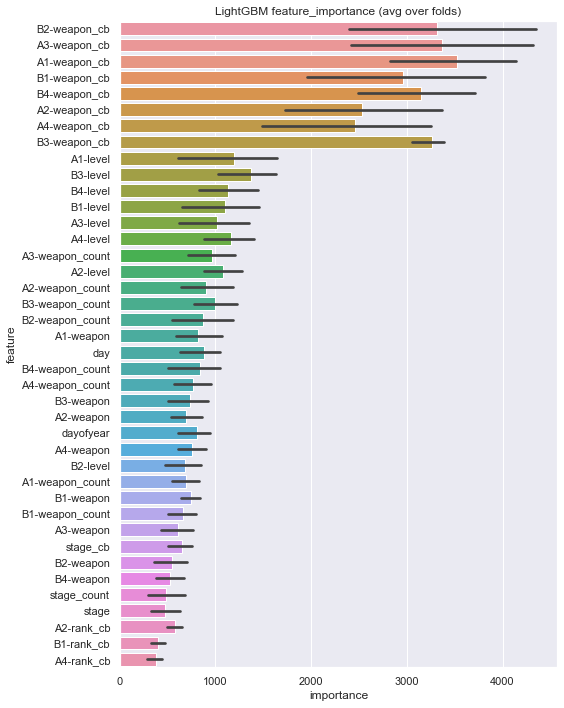

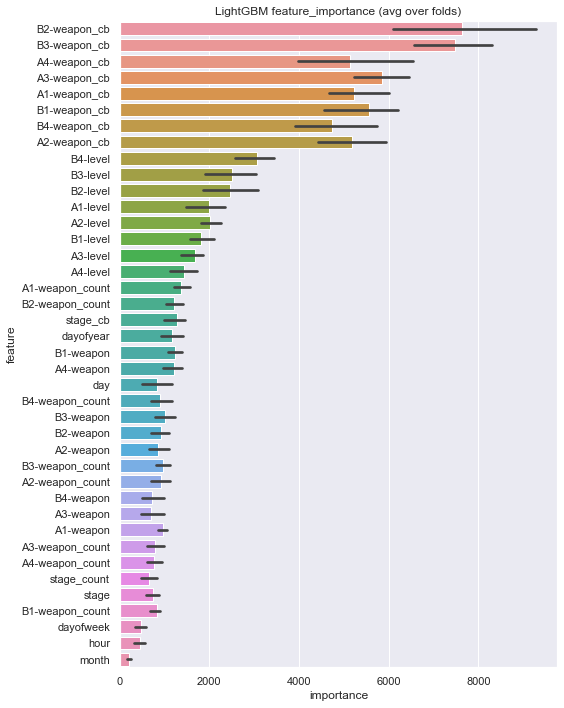

In [8]:
def train_seg(df):
    """lobby-modeでセグメンテーション"""
    # gachi
    df_gac = df[df["lobby-mode"] == "gachi"]
    df_gac = df_gac.drop("lobby-mode", axis=1)
    base_train(df_gac, dict_enc_flag={"count": True, "target": False, "catboost": True}, out_dir=f"{OUT_MODEL}/gachi")

    # regular
    rank_not_in_cols = [s for s in df.columns.to_list() if 'rank' not in s]  # rankを含まない列名
    df = df[rank_not_in_cols]
    df_reg = df[df["lobby-mode"] == "regular"]
    df_reg = df_reg.drop("lobby-mode", axis=1)
    base_train(df_reg, dict_enc_flag={"count": True, "target": False, "catboost": True}, out_dir=f"{OUT_MODEL}/regular")
    
df_all = pd.read_csv(f"{DATA_DIR}/preprocess.csv", index_col=0)
train_seg(df_all)

In [9]:
class Predict:
    """modelファイルから予測する"""
    def __init__(self, csv=f"{DATA_DIR}/preprocess.csv", model_dir=OUT_MODEL):
        self.csv = csv
        self.model_dir = model_dir
    
    @staticmethod
    def _enc(tr_df, te_df, dict_enc_flag):
        if dict_enc_flag["count"]:
            # カウントエンコディング
            tr_df, te_df = count_encoder(tr_df, te_df, cat_features=None)
        if dict_enc_flag["target"]:
            # ターゲットエンコディング
            tr_df, te_df = target_encoder(tr_df, te_df, target_col="y", cat_features=None)
        if dict_enc_flag["catboost"]:
            # CatBoostエンコディング
            tr_df, te_df = catboost_encoder(tr_df, te_df, target_col="y", cat_features=None)
        # ラベルエンコディング
        cate_cols = tr_df.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
        for col in cate_cols:
            tr_df[col], uni = pd.factorize(tr_df[col])
            te_df[col], uni = pd.factorize(te_df[col])
        return tr_df, te_df

    @staticmethod
    def predict(tr_df, te_df, model_paths, dict_enc_flag):
        sub_preds = np.zeros(te_df.shape[0])
        test_probas = {}
        for m_p in model_paths:
            print(m_p)
            clf = joblib.load(m_p)

            #print(tr_df.shape, te_df.shape)
            tr_df, te_df = Predict()._enc(tr_df, te_df, dict_enc_flag)
            if "y" in te_df.columns.to_list():
                te_df = te_df.drop("y", axis=1)
            # print(tr_df.shape, te_df.shape)

            # testの確信度
            test_probas[f"{pathlib.Path(m_p).name}"] = clf.predict_proba(te_df, num_iteration=clf.best_iteration_)[:, 1]
            # print(test_probas[f"{pathlib.Path(m_p).name}"])
            sub_preds += test_probas[f"{pathlib.Path(m_p).name}"] / len(model_paths)
        return sub_preds

    def main(self, l_mode, dict_enc_flag={"count": True, "target": False, "catboost": True}):
        #l_mode = "regular"
        df_all = pd.read_csv(self.csv, index_col=0)

        if l_mode == "regular":
            rank_not_in_cols = [s for s in df_all.columns.to_list() if 'rank' not in s]  # rankを含まない列名
            df_all = df_all[rank_not_in_cols]
        df_all = df_all[df_all["lobby-mode"] == l_mode]
        df_all = df_all.drop("lobby-mode", axis=1)

        tr_df = df_all[df_all["y"].notnull()]
        te_df = df_all[df_all["y"].isnull()]

        model_paths = sorted(glob.glob(f"{self.model_dir}/*.model"))
        sub_preds = Predict().predict(tr_df, te_df, model_paths, dict_enc_flag)
        #print(sub_preds)
        te_df["sub_pred_mean"] = sub_preds
        return te_df
        
te_df_reg = Predict(model_dir=f"{OUT_MODEL}/regular").main("regular")
te_df_gac = Predict(model_dir=f"{OUT_MODEL}/gachi").main("gachi")
te_df = te_df_reg.append(te_df_gac)
display(te_df.sort_index(axis=1, ascending=True))

C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-1.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-2.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-3.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-4.model


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-1.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-2.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-3.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-4.model


,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,A4-rank,A4-weapon,B1-level,B1-rank,B1-weapon,B2-level,B2-rank,B2-weapon,B3-level,B3-rank,B3-weapon,B4-level,B4-rank,B4-weapon,day,dayofweek,dayofyear,hour,mode,month,stage,sub_pred_mean,weekend,y,year
66116,154,NaN,splatscope,97.0,NaN,dualsweeper_custom,37.0,NaN,dualsweeper_custom,24.0,NaN,longblaster,34,NaN,promodeler_rg,87.0,NaN,maneuver,77.0,NaN,sshooter_collabo,44.0,NaN,prime,2,5,306,14,nawabari,11,mozuku,0.617917,1,NaN,2019
66123,261,NaN,bucketslosher_soda,96.0,NaN,wakaba,101.0,NaN,splatcharger_becchu,297.0,NaN,sshooter_collabo,160,NaN,sharp_neo,287.0,NaN,soytuber,323.0,NaN,soytuber_custom,8.0,NaN,sshooter_becchu,30,0,364,12,nawabari,12,kombu,0.505639,0,NaN,2019
66125,198,NaN,variableroller_foil,198.0,NaN,wakaba,142.0,NaN,furo,36.0,NaN,campingshelter,174,NaN,sshooter_becchu,76.0,NaN,sharp,82.0,NaN,dualsweeper,128.0,NaN,sshooter_collabo,17,1,351,14,nawabari,12,shottsuru,0.514033,0,NaN,2019
66126,123,NaN,momiji,33.0,NaN,jetsweeper,72.0,NaN,nzap89,102.0,NaN,sputtery_clear,117,NaN,promodeler_mg,6.0,NaN,sshooter,40.0,NaN,nzap89,84.0,NaN,splatroller,14,5,348,18,nawabari,12,engawa,0.528150,1,NaN,2019
66128,49,NaN,96gal_deco,45.0,NaN,promodeler_mg,85.0,NaN,furo,205.0,NaN,barrelspinner_deco,51,NaN,furo,58.0,NaN,explosher,58.0,NaN,furo_deco,63.0,NaN,sputtery_clear,18,4,291,2,nawabari,10,manta,0.597926,0,NaN,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94440,67,x,prime_becchu,62.0,x,splatroller,136.0,x,bold,131.0,x,furo,139,x,longblaster_custom,152.0,x,hissen,240.0,x,prime_becchu,150.0,x,nzap83,11,4,284,16,yagura,10,battera,0.560530,0,NaN,2019
94441,25,c-,longblaster_necro,18.0,c-,splatroller_collabo,19.0,c,quadhopper_black,18.0,c-,bold,10,c-,hokusai,18.0,c,bamboo14mk1,17.0,c-,nzap89,35.0,c+,dualsweeper,20,6,293,12,yagura,10,anchovy,0.604370,1,NaN,2019
94442,386,x,furo,136.0,x,kugelschreiber,198.0,x,heroroller_replica,512.0,x,clashblaster_neo,62,x,rapid_becchu,250.0,x,bamboo14mk1,257.0,x,carbon_deco,243.0,x,l3reelgun_d,14,5,348,0,yagura,12,zatou,0.507501,1,NaN,2019
94443,185,s+,maneuver_becchu,103.0,s+,wakaba,202.0,s+,furo,477.0,s+,pablo,89,s+,dualsweeper_custom,298.0,s+,bold,152.0,s+,hokusai,130.0,s+,ochiba,12,5,285,4,asari,10,hokke,0.507971,1,NaN,2019


In [11]:
te_df["sub_pred_mean"].dropna()

66116    0.617917
66123    0.505639
66125    0.514033
66126    0.528150
66128    0.597926
           ...   
94440    0.560530
94441    0.604370
94442    0.507501
94443    0.507971
94444    0.483076
Name: sub_pred_mean, Length: 28340, dtype: float64

# eng1.csv

Starting LightGBM. Train shape: (66105, 121), test shape: (28340, 121)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 274), valid shape: (16527, 274)
len(feats): 273
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.378797	training's binary_logloss: 0.667412	valid_1's binary_error: 0.448418	valid_1's binary_logloss: 0.684608
[400]	training's binary_error: 0.361229	training's binary_logloss: 0.653463	valid_1's binary_error: 0.449507	valid_1's binary_logloss: 0.683517
Early stopping, best iteration is:
[326]	training's binary_error: 0.365081	training's binary_logloss: 0.658204	valid_1's binary_error: 0.446542	valid_1's binary_logloss: 0.683697
Fold  1 error : 0.446542


1it [00:22, 22.89s/it]

run encoding Train shape: (49579, 274), valid shape: (16526, 274)
len(feats): 273
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.377277	training's binary_logloss: 0.666716	valid_1's binary_error: 0.461031	valid_1's binary_logloss: 0.686094
[400]	training's binary_error: 0.35745	training's binary_logloss: 0.652524	valid_1's binary_error: 0.459034	valid_1's binary_logloss: 0.685695
Early stopping, best iteration is:
[329]	training's binary_error: 0.361685	training's binary_logloss: 0.657042	valid_1's binary_error: 0.459821	valid_1's binary_logloss: 0.685443
Fold  2 error : 0.459821


2it [00:46, 22.97s/it]

run encoding Train shape: (49579, 274), valid shape: (16526, 274)
len(feats): 273
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.375098	training's binary_logloss: 0.666691	valid_1's binary_error: 0.45256	valid_1's binary_logloss: 0.684923
[400]	training's binary_error: 0.356038	training's binary_logloss: 0.652342	valid_1's binary_error: 0.452378	valid_1's binary_logloss: 0.684081
Early stopping, best iteration is:
[245]	training's binary_error: 0.368886	training's binary_logloss: 0.662963	valid_1's binary_error: 0.448566	valid_1's binary_logloss: 0.684404
Fold  3 error : 0.448566


3it [01:08, 22.87s/it]

run encoding Train shape: (49579, 274), valid shape: (16526, 274)
len(feats): 273
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.381008	training's binary_logloss: 0.667675	valid_1's binary_error: 0.451652	valid_1's binary_logloss: 0.684861
[400]	training's binary_error: 0.360253	training's binary_logloss: 0.653862	valid_1's binary_error: 0.446993	valid_1's binary_logloss: 0.683204
Early stopping, best iteration is:
[354]	training's binary_error: 0.363138	training's binary_logloss: 0.656621	valid_1's binary_error: 0.445722	valid_1's binary_logloss: 0.68341
Fold  4 error : 0.445722


4it [01:31, 22.97s/it]


Full error score 0.450163


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


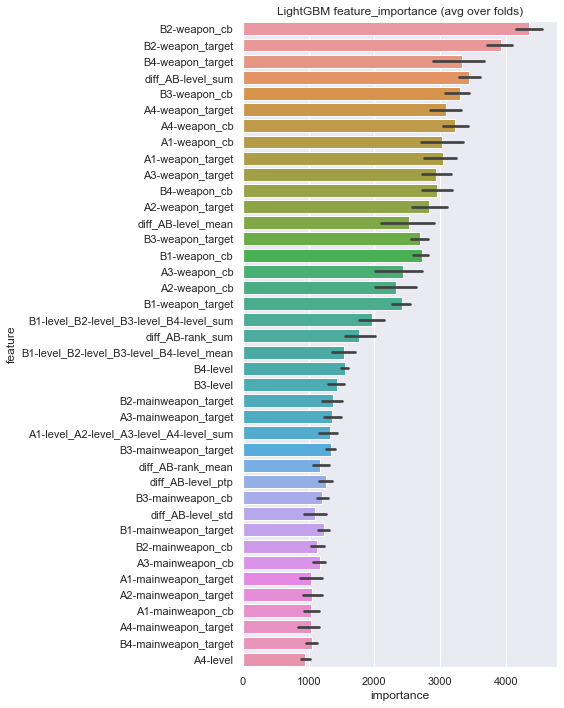

In [11]:
df_all = pd.read_csv(f"{DATA_DIR}/eng1.csv", index_col=0)
base_train(df_all, dict_enc_flag={"count": True, "target": True, "catboost": True})

Starting LightGBM. Train shape: (66105, 121), test shape: (28340, 121)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 223), valid shape: (16527, 223)
len(feats): 222
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.376699	training's binary_logloss: 0.670288	valid_1's binary_error: 0.450293	valid_1's binary_logloss: 0.684622
[400]	training's binary_error: 0.355359	training's binary_logloss: 0.655976	valid_1's binary_error: 0.446724	valid_1's binary_logloss: 0.68253
[600]	training's binary_error: 0.340938	training's binary_logloss: 0.64572	valid_1's binary_error: 0.445634	valid_1's binary_logloss: 0.682135
Early stopping, best iteration is:
[531]	training's binary_error: 0.345617	training's binary_logloss: 0.648867	valid_1's binary_error: 0.444545	valid_1's binary_logloss: 0.68216
Fold  1 error : 0.444545


1it [00:16, 16.89s/it]

run encoding Train shape: (49579, 223), valid shape: (16526, 223)
len(feats): 222
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.37885	training's binary_logloss: 0.669524	valid_1's binary_error: 0.456614	valid_1's binary_logloss: 0.685776
[400]	training's binary_error: 0.353738	training's binary_logloss: 0.654976	valid_1's binary_error: 0.452741	valid_1's binary_logloss: 0.684384
Early stopping, best iteration is:
[394]	training's binary_error: 0.354142	training's binary_logloss: 0.655345	valid_1's binary_error: 0.452741	valid_1's binary_logloss: 0.684398
Fold  2 error : 0.452741


2it [00:33, 16.70s/it]

run encoding Train shape: (49579, 223), valid shape: (16526, 223)
len(feats): 222
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.376692	training's binary_logloss: 0.66975	valid_1's binary_error: 0.452983	valid_1's binary_logloss: 0.685001
[400]	training's binary_error: 0.350895	training's binary_logloss: 0.655043	valid_1's binary_error: 0.454133	valid_1's binary_logloss: 0.683165
Early stopping, best iteration is:
[249]	training's binary_error: 0.367252	training's binary_logloss: 0.665531	valid_1's binary_error: 0.448445	valid_1's binary_logloss: 0.68423
Fold  3 error : 0.448445


3it [00:48, 16.42s/it]

run encoding Train shape: (49579, 223), valid shape: (16526, 223)
len(feats): 222
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.384618	training's binary_logloss: 0.670647	valid_1's binary_error: 0.456251	valid_1's binary_logloss: 0.685182
[400]	training's binary_error: 0.354565	training's binary_logloss: 0.656557	valid_1's binary_error: 0.449292	valid_1's binary_logloss: 0.683103
[600]	training's binary_error: 0.339075	training's binary_logloss: 0.646159	valid_1's binary_error: 0.448989	valid_1's binary_logloss: 0.682563
Early stopping, best iteration is:
[551]	training's binary_error: 0.342726	training's binary_logloss: 0.648474	valid_1's binary_error: 0.448021	valid_1's binary_logloss: 0.682463
Fold  4 error : 0.448021


4it [01:05, 16.49s/it]


Full error score 0.448438


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


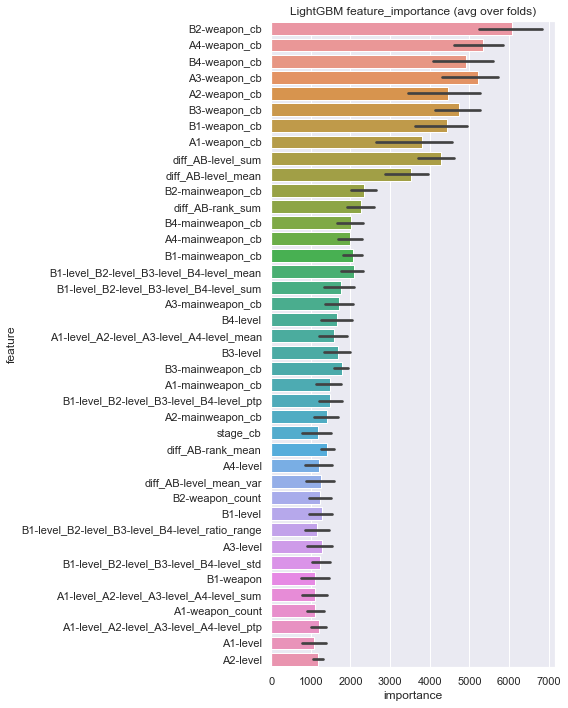

In [10]:
df_all = pd.read_csv(f"{DATA_DIR}/eng1.csv", index_col=0)
base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": True})

Starting LightGBM. Train shape: (66105, 85), test shape: (28340, 85)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 187), valid shape: (16527, 187)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.385836	training's binary_logloss: 0.672015	valid_1's binary_error: 0.455013	valid_1's binary_logloss: 0.686676
[400]	training's binary_error: 0.36016	training's binary_logloss: 0.658632	valid_1's binary_error: 0.453621	valid_1's binary_logloss: 0.685427
Early stopping, best iteration is:
[300]	training's binary_error: 0.370487	training's binary_logloss: 0.664806	valid_1's binary_error: 0.449567	valid_1's binary_logloss: 0.685862
Fold  1 error : 0.449567


1it [00:15, 15.72s/it]

run encoding Train shape: (49579, 187), valid shape: (16526, 187)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.385425	training's binary_logloss: 0.671526	valid_1's binary_error: 0.463573	valid_1's binary_logloss: 0.687716
[400]	training's binary_error: 0.358801	training's binary_logloss: 0.65778	valid_1's binary_error: 0.462786	valid_1's binary_logloss: 0.686847
Early stopping, best iteration is:
[221]	training's binary_error: 0.380867	training's binary_logloss: 0.669946	valid_1's binary_error: 0.460729	valid_1's binary_logloss: 0.6875
Fold  2 error : 0.460729


2it [00:31, 15.60s/it]

run encoding Train shape: (49579, 187), valid shape: (16526, 187)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.38597	training's binary_logloss: 0.671925	valid_1's binary_error: 0.46091	valid_1's binary_logloss: 0.686904
[400]	training's binary_error: 0.358821	training's binary_logloss: 0.658676	valid_1's binary_error: 0.458187	valid_1's binary_logloss: 0.685713
Early stopping, best iteration is:
[294]	training's binary_error: 0.369935	training's binary_logloss: 0.665138	valid_1's binary_error: 0.456432	valid_1's binary_logloss: 0.68615
Fold  3 error : 0.456432


3it [00:46, 15.60s/it]

run encoding Train shape: (49579, 187), valid shape: (16526, 187)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.388874	training's binary_logloss: 0.672393	valid_1's binary_error: 0.46085	valid_1's binary_logloss: 0.687265
[400]	training's binary_error: 0.362654	training's binary_logloss: 0.659256	valid_1's binary_error: 0.454859	valid_1's binary_logloss: 0.685688
[600]	training's binary_error: 0.345691	training's binary_logloss: 0.648997	valid_1's binary_error: 0.453709	valid_1's binary_logloss: 0.685049
Early stopping, best iteration is:
[553]	training's binary_error: 0.349382	training's binary_logloss: 0.651151	valid_1's binary_error: 0.452439	valid_1's binary_logloss: 0.685021
Fold  4 error : 0.452439


4it [01:03, 15.81s/it]


Full error score 0.454792


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


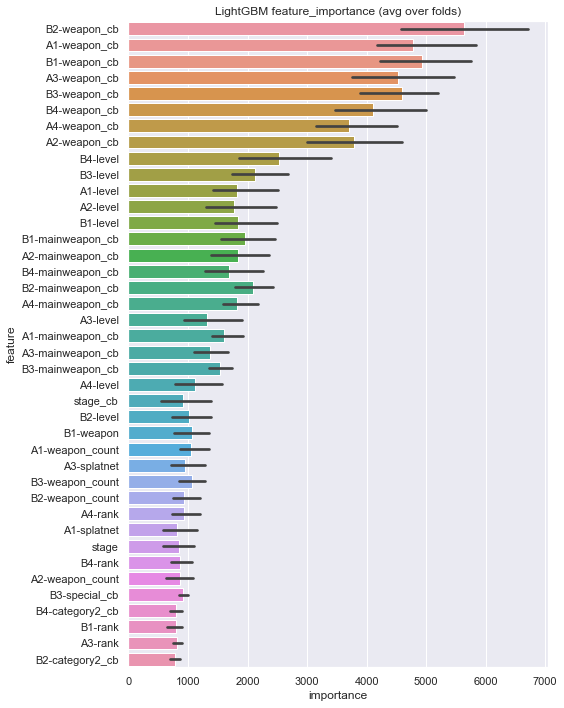

In [25]:
# old
df_all = pd.read_csv(f"{DATA_DIR}/eng1.csv", index_col=0)
base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": True})

Starting LightGBM. Train shape: (51669, 84), test shape: (22068, 84)


0it [00:00, ?it/s]

run encoding Train shape: (38751, 184), valid shape: (12918, 184)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.372868	training's binary_logloss: 0.674361	valid_1's binary_error: 0.467332	valid_1's binary_logloss: 0.689785
Early stopping, best iteration is:
[123]	training's binary_error: 0.396119	training's binary_logloss: 0.680634	valid_1's binary_error: 0.463617	valid_1's binary_logloss: 0.690358
Fold  1 error : 0.463617


1it [00:11, 11.90s/it]

run encoding Train shape: (38752, 184), valid shape: (12917, 184)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.373426	training's binary_logloss: 0.673608	valid_1's binary_error: 0.467059	valid_1's binary_logloss: 0.690508
Early stopping, best iteration is:
[168]	training's binary_error: 0.379464	training's binary_logloss: 0.676119	valid_1's binary_error: 0.465743	valid_1's binary_logloss: 0.690637
Fold  2 error : 0.465743


2it [00:23, 11.94s/it]

run encoding Train shape: (38752, 184), valid shape: (12917, 184)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.370845	training's binary_logloss: 0.673656	valid_1's binary_error: 0.472014	valid_1's binary_logloss: 0.69032
Early stopping, best iteration is:
[143]	training's binary_error: 0.385528	training's binary_logloss: 0.678385	valid_1's binary_error: 0.470698	valid_1's binary_logloss: 0.690631
Fold  3 error : 0.470698


3it [00:35, 11.98s/it]

run encoding Train shape: (38752, 184), valid shape: (12917, 184)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.373632	training's binary_logloss: 0.67346	valid_1's binary_error: 0.471394	valid_1's binary_logloss: 0.690704
Early stopping, best iteration is:
[195]	training's binary_error: 0.375052	training's binary_logloss: 0.67385	valid_1's binary_error: 0.47031	valid_1's binary_logloss: 0.690719
Fold  4 error : 0.470310


4it [00:47, 11.91s/it]


Full error score 0.467592


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting LightGBM. Train shape: (14436, 76), test shape: (6272, 76)


0it [00:00, ?it/s]

run encoding Train shape: (10827, 176), valid shape: (3609, 176)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.328808	training's binary_logloss: 0.638573	valid_1's binary_error: 0.406207	valid_1's binary_logloss: 0.667633
[400]	training's binary_error: 0.298421	training's binary_logloss: 0.608935	valid_1's binary_error: 0.399557	valid_1's binary_logloss: 0.662433
[600]	training's binary_error: 0.283089	training's binary_logloss: 0.587442	valid_1's binary_error: 0.399002	valid_1's binary_logloss: 0.660374
[800]	training's binary_error: 0.271636	training's binary_logloss: 0.570011	valid_1's binary_error: 0.39069	valid_1's binary_logloss: 0.660245
Early stopping, best iteration is:
[779]	training's binary_error: 0.273206	training's binary_logloss: 0.571727	valid_1's binary_error: 0.390136	valid_1's binary_logloss: 0.66017
Fold  1 error : 0.390136


1it [00:05,  5.28s/it]

run encoding Train shape: (10827, 176), valid shape: (3609, 176)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.335919	training's binary_logloss: 0.637205	valid_1's binary_error: 0.424771	valid_1's binary_logloss: 0.672879
[400]	training's binary_error: 0.300822	training's binary_logloss: 0.607838	valid_1's binary_error: 0.412857	valid_1's binary_logloss: 0.668155
[600]	training's binary_error: 0.282442	training's binary_logloss: 0.585983	valid_1's binary_error: 0.407592	valid_1's binary_logloss: 0.66587
[800]	training's binary_error: 0.267664	training's binary_logloss: 0.5686	valid_1's binary_error: 0.402328	valid_1's binary_logloss: 0.666259
Early stopping, best iteration is:
[619]	training's binary_error: 0.281241	training's binary_logloss: 0.583997	valid_1's binary_error: 0.407869	valid_1's binary_logloss: 0.665749
Fold  2 error : 0.407869


2it [00:10,  5.22s/it]

run encoding Train shape: (10827, 176), valid shape: (3609, 176)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.340999	training's binary_logloss: 0.639178	valid_1's binary_error: 0.407038	valid_1's binary_logloss: 0.668576
[400]	training's binary_error: 0.298328	training's binary_logloss: 0.609782	valid_1's binary_error: 0.395677	valid_1's binary_logloss: 0.662565
[600]	training's binary_error: 0.282996	training's binary_logloss: 0.58774	valid_1's binary_error: 0.391798	valid_1's binary_logloss: 0.660763
Early stopping, best iteration is:
[532]	training's binary_error: 0.287337	training's binary_logloss: 0.594555	valid_1's binary_error: 0.387919	valid_1's binary_logloss: 0.661069
Fold  3 error : 0.387919


3it [00:15,  5.16s/it]

run encoding Train shape: (10827, 176), valid shape: (3609, 176)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.340722	training's binary_logloss: 0.637892	valid_1's binary_error: 0.412857	valid_1's binary_logloss: 0.671389
[400]	training's binary_error: 0.299437	training's binary_logloss: 0.609095	valid_1's binary_error: 0.400388	valid_1's binary_logloss: 0.665767
[600]	training's binary_error: 0.281518	training's binary_logloss: 0.587931	valid_1's binary_error: 0.391521	valid_1's binary_logloss: 0.663409
[800]	training's binary_error: 0.269327	training's binary_logloss: 0.570823	valid_1's binary_error: 0.392352	valid_1's binary_logloss: 0.66278
Early stopping, best iteration is:
[616]	training's binary_error: 0.279302	training's binary_logloss: 0.586243	valid_1's binary_error: 0.388196	valid_1's binary_logloss: 0.663341
Fold  4 error : 0.388196


4it [00:20,  5.17s/it]


Full error score 0.393530
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-1.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-2.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-3.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/regular\lgb-4.model


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-1.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-2.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-3.model
C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train/gachi\lgb-4.model


,A1-category1,A1-category2,A1-level,A1-mainweapon,A1-rank,A1-special,A1-splatnet,A1-subweapon,A1-weapon,A2-category1,A2-category2,A2-level,A2-mainweapon,A2-rank,A2-special,A2-splatnet,A2-subweapon,A2-weapon,A3-category1,A3-category2,A3-level,A3-mainweapon,A3-rank,A3-special,A3-splatnet,A3-subweapon,A3-weapon,A4-category1,A4-category2,A4-level,A4-mainweapon,A4-rank,A4-special,A4-splatnet,A4-subweapon,A4-weapon,A_n_player,B1-category1,B1-category2,B1-level,B1-mainweapon,B1-rank,B1-special,B1-splatnet,B1-subweapon,B1-weapon,B2-category1,B2-category2,B2-level,B2-mainweapon,B2-rank,B2-special,B2-splatnet,B2-subweapon,B2-weapon,B3-category1,B3-category2,B3-level,B3-mainweapon,B3-rank,B3-special,B3-splatnet,B3-subweapon,B3-weapon,B4-category1,B4-category2,B4-level,B4-mainweapon,B4-rank,B4-special,B4-splatnet,B4-subweapon,B4-weapon,B_n_player,day,dayofweek,dayofyear,hour,mode,month,stage,sub_pred_mean,weekend,y,year
66116,charger,charger,154,splatcharger,NaN,presser,2020,splashbomb,splatscope,shooter,maneuver,97.0,dualsweeper,NaN,amefurashi,5031,splashbomb,dualsweeper_custom,shooter,maneuver,37.0,dualsweeper,NaN,amefurashi,5031,splashbomb,dualsweeper_custom,shooter,blaster,24.0,longblaster,NaN,amefurashi,220.0,kyubanbomb,longblaster,4,shooter,shooter,34,promodeler_mg,NaN,sphere,31,sprinkler,promodeler_rg,shooter,maneuver,87.0,maneuver,NaN,missile,5010,quickbomb,maneuver,shooter,shooter,77.0,sshooter,NaN,jetpack,41.0,splashbomb,sshooter_collabo,shooter,shooter,44.0,prime,NaN,amefurashi,70.0,pointsensor,prime,4,2,5,306,14,nawabari,11,mozuku,0.595388,1,NaN,2019
66123,slosher,slosher,261,bucketslosher,NaN,quickbomb_pitcher,3002,splashbomb,bucketslosher_soda,shooter,shooter,96.0,wakaba,NaN,armor,10,splashbomb,wakaba,charger,charger,101.0,splatcharger,NaN,sphere,2012,sprinkler,splatcharger_becchu,shooter,shooter,297.0,sshooter,NaN,jetpack,41.0,splashbomb,sshooter_collabo,4,shooter,shooter,160,sharp,NaN,kyubanbomb_pitcher,21,quickbomb,sharp_neo,charger,charger,287.0,soytuber,NaN,chakuchi,2060,kyubanbomb,soytuber,charger,charger,323.0,soytuber,NaN,jetpack,2061.0,curlingbomb,soytuber_custom,shooter,shooter,8.0,sshooter,NaN,missile,42.0,kyubanbomb,sshooter_becchu,4,30,0,364,12,nawabari,12,kombu,0.504778,0,NaN,2019
66125,roller,roller,198,variableroller,NaN,missile,1031,kyubanbomb,variableroller_foil,shooter,shooter,198.0,wakaba,NaN,armor,10,splashbomb,wakaba,slosher,slosher,142.0,furo,NaN,amefurashi,3030,splashshield,furo,brella,brella,36.0,campingshelter,NaN,bubble,6010.0,jumpbeacon,campingshelter,4,shooter,shooter,174,sshooter,NaN,missile,42,kyubanbomb,sshooter_becchu,shooter,shooter,76.0,sharp,NaN,jetpack,20,poisonmist,sharp,shooter,maneuver,82.0,dualsweeper,NaN,missile,5030.0,pointsensor,dualsweeper,shooter,shooter,128.0,sshooter,NaN,jetpack,41.0,splashbomb,sshooter_collabo,4,17,1,351,14,nawabari,12,shottsuru,0.481946,0,NaN,2019
66126,shooter,shooter,123,wakaba,NaN,amefurashi,11,robotbomb,momiji,shooter,shooter,33.0,jetsweeper,NaN,missile,90,poisonmist,jetsweeper,shooter,shooter,72.0,nzap85,NaN,missile,61,robotbomb,nzap89,shooter,maneuver,102.0,sputtery,NaN,chakuchi,5002.0,torpedo,sputtery_clear,4,shooter,shooter,117,promodeler_mg,NaN,curlingbomb_pitcher,30,kyubanbomb,promodeler_mg,shooter,shooter,6.0,sshooter,NaN,chakuchi,40,quickbomb,sshooter,shooter,shooter,40.0,nzap85,NaN,missile,61.0,robotbomb,nzap89,roller,roller,84.0,splatroller,NaN,chakuchi,1010.0,curlingbomb,splatroller,4,14,5,348,18,nawabari,12,engawa,0.510452,1,NaN,2019
66128,shooter,shooter,49,96gal,NaN,chakuchi,81,splashshield,96gal_deco,shooter,shooter,45.0,promodeler_mg,NaN,curlingbomb_pitcher,30,kyubanbomb,promodeler_mg,slosher,slosher,85.0,furo,NaN,amefurashi,3030,splashshield,furo,splatling,splatling,205.0,barrelspinner,NaN,bubble,4011.0,splashshield,barrelspinner_deco,4,slosher,slosher,51,furo,NaN,amefurashi,3030,splashshield,furo,slosher,slosher,58.0,explosher,NaN,bubble,3040,sprinkler,explosher,slosher,slosher,58.0,furo,NaN,kyubanbomb_pitcher,3031.0,sprinkler,furo_deco,

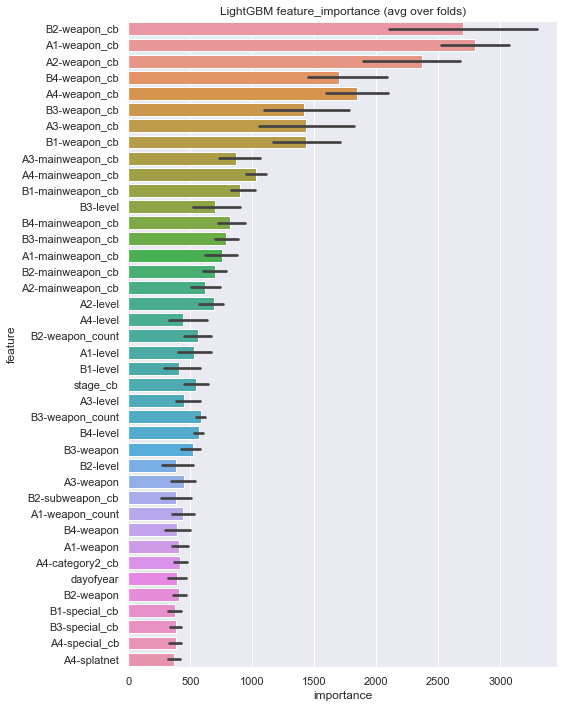

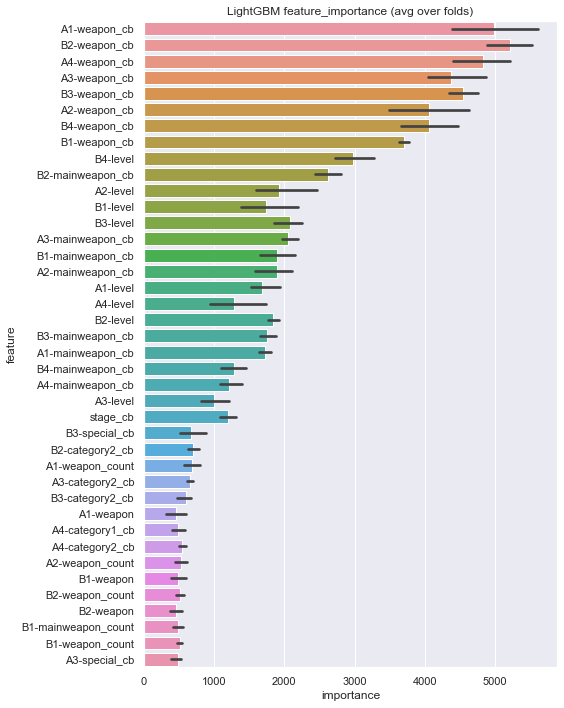

In [24]:
# セグメンテーション
df_all = pd.read_csv(f"{DATA_DIR}/eng1.csv", index_col=0)
train_seg(df_all)

te_df_reg = Predict(csv=f"{DATA_DIR}/eng1.csv", model_dir=f"{OUT_MODEL}/regular").main("regular")
te_df_gac = Predict(csv=f"{DATA_DIR}/eng1.csv", model_dir=f"{OUT_MODEL}/gachi").main("gachi")
te_df = te_df_reg.append(te_df_gac)
display(te_df.sort_index(axis=1, ascending=True))

df_sub = pd.DataFrame({"y": [int(x) for x in te_df["sub_pred_mean"].values >= 0.5]}).reset_index()
df_sub.columns = ["id", "y"]
df_sub.to_csv(f"{OUT_MODEL}/submission_segmentation.csv", index=False)

# eng2.csv

Starting LightGBM. Train shape: (66105, 387), test shape: (28340, 387)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 489), valid shape: (16527, 489)
len(feats): 488
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.370225	training's binary_logloss: 0.668536	valid_1's binary_error: 0.448236	valid_1's binary_logloss: 0.683922
[400]	training's binary_error: 0.346323	training's binary_logloss: 0.653548	valid_1's binary_error: 0.442791	valid_1's binary_logloss: 0.681545
[600]	training's binary_error: 0.333031	training's binary_logloss: 0.642377	valid_1's binary_error: 0.444485	valid_1's binary_logloss: 0.68114
Early stopping, best iteration is:
[417]	training's binary_error: 0.344568	training's binary_logloss: 0.652524	valid_1's binary_error: 0.442065	valid_1's binary_logloss: 0.681446
Fold  1 error : 0.442065


1it [00:19, 19.55s/it]

run encoding Train shape: (49579, 489), valid shape: (16526, 489)
len(feats): 488
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.374675	training's binary_logloss: 0.66806	valid_1's binary_error: 0.45855	valid_1's binary_logloss: 0.685611
[400]	training's binary_error: 0.347284	training's binary_logloss: 0.652525	valid_1's binary_error: 0.45492	valid_1's binary_logloss: 0.684377
[600]	training's binary_error: 0.3325	training's binary_logloss: 0.641331	valid_1's binary_error: 0.453044	valid_1's binary_logloss: 0.684508
Early stopping, best iteration is:
[477]	training's binary_error: 0.341253	training's binary_logloss: 0.647922	valid_1's binary_error: 0.452983	valid_1's binary_logloss: 0.68433
Fold  2 error : 0.452983


2it [00:39, 19.69s/it]

run encoding Train shape: (49579, 489), valid shape: (16526, 489)
len(feats): 488
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.369673	training's binary_logloss: 0.667804	valid_1's binary_error: 0.453286	valid_1's binary_logloss: 0.684538
[400]	training's binary_error: 0.343472	training's binary_logloss: 0.652276	valid_1's binary_error: 0.450805	valid_1's binary_logloss: 0.682658
[600]	training's binary_error: 0.328587	training's binary_logloss: 0.640819	valid_1's binary_error: 0.452802	valid_1's binary_logloss: 0.682359
Early stopping, best iteration is:
[408]	training's binary_error: 0.342766	training's binary_logloss: 0.65177	valid_1's binary_error: 0.448868	valid_1's binary_logloss: 0.682628
Fold  3 error : 0.448868


3it [00:59, 19.78s/it]

run encoding Train shape: (49579, 489), valid shape: (16526, 489)
len(feats): 488
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.376369	training's binary_logloss: 0.66855	valid_1's binary_error: 0.45256	valid_1's binary_logloss: 0.684735
[400]	training's binary_error: 0.348656	training's binary_logloss: 0.653791	valid_1's binary_error: 0.446266	valid_1's binary_logloss: 0.682654
[600]	training's binary_error: 0.331693	training's binary_logloss: 0.642729	valid_1's binary_error: 0.445601	valid_1's binary_logloss: 0.682107
[800]	training's binary_error: 0.32062	training's binary_logloss: 0.634344	valid_1's binary_error: 0.444572	valid_1's binary_logloss: 0.682027
Early stopping, best iteration is:
[741]	training's binary_error: 0.323161	training's binary_logloss: 0.636673	valid_1's binary_error: 0.442636	valid_1's binary_logloss: 0.682031
Fold  4 error : 0.442636


4it [01:20, 20.22s/it]


Full error score 0.446638


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


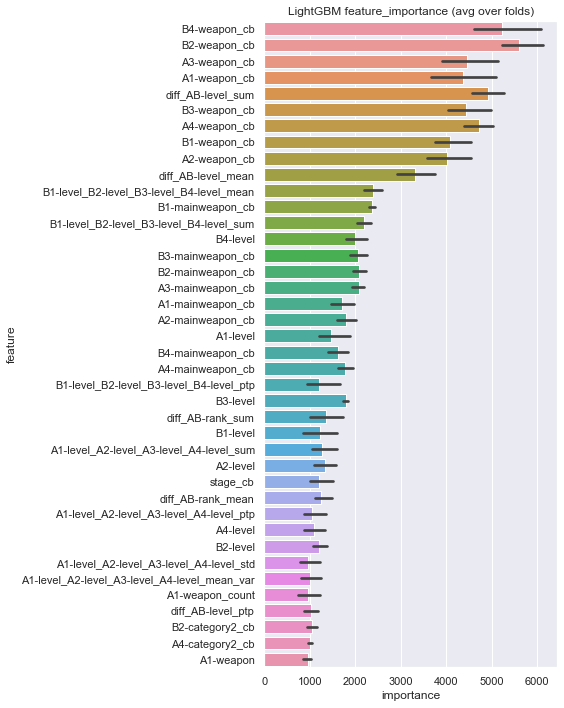

In [12]:
df_all = pd.read_csv(f"{DATA_DIR}/eng2.csv", index_col=0)
base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": True})

Starting LightGBM. Train shape: (66105, 275), test shape: (28340, 275)


0it [00:00, ?it/s]

run encoding Train shape: (49578, 459), valid shape: (16527, 459)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.364395	training's binary_logloss: 0.65673	valid_1's binary_error: 0.455195	valid_1's binary_logloss: 0.686412
Early stopping, best iteration is:
[195]	training's binary_error: 0.365646	training's binary_logloss: 0.6576	valid_1's binary_error: 0.454105	valid_1's binary_logloss: 0.686329
Fold  1 error : 0.454105


1it [01:33, 93.18s/it]

run encoding Train shape: (49579, 459), valid shape: (16526, 459)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.364469	training's binary_logloss: 0.656143	valid_1's binary_error: 0.465932	valid_1's binary_logloss: 0.688327
Early stopping, best iteration is:
[150]	training's binary_error: 0.37766	training's binary_logloss: 0.663104	valid_1's binary_error: 0.468474	valid_1's binary_logloss: 0.688207
Fold  2 error : 0.468474


2it [03:04, 92.50s/it]

run encoding Train shape: (49579, 459), valid shape: (16526, 459)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.361181	training's binary_logloss: 0.65563	valid_1's binary_error: 0.461818	valid_1's binary_logloss: 0.686902
[400]	training's binary_error: 0.338772	training's binary_logloss: 0.635654	valid_1's binary_error: 0.456493	valid_1's binary_logloss: 0.687949
Early stopping, best iteration is:
[270]	training's binary_error: 0.350753	training's binary_logloss: 0.647603	valid_1's binary_error: 0.458369	valid_1's binary_logloss: 0.686755
Fold  3 error : 0.458369


3it [04:34, 91.99s/it]

run encoding Train shape: (49579, 459), valid shape: (16526, 459)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.367938	training's binary_logloss: 0.656851	valid_1's binary_error: 0.461334	valid_1's binary_logloss: 0.687818
Early stopping, best iteration is:
[195]	training's binary_error: 0.368503	training's binary_logloss: 0.657694	valid_1's binary_error: 0.461999	valid_1's binary_logloss: 0.687741
Fold  4 error : 0.461999


4it [06:07, 91.79s/it]


Full error score 0.460737


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


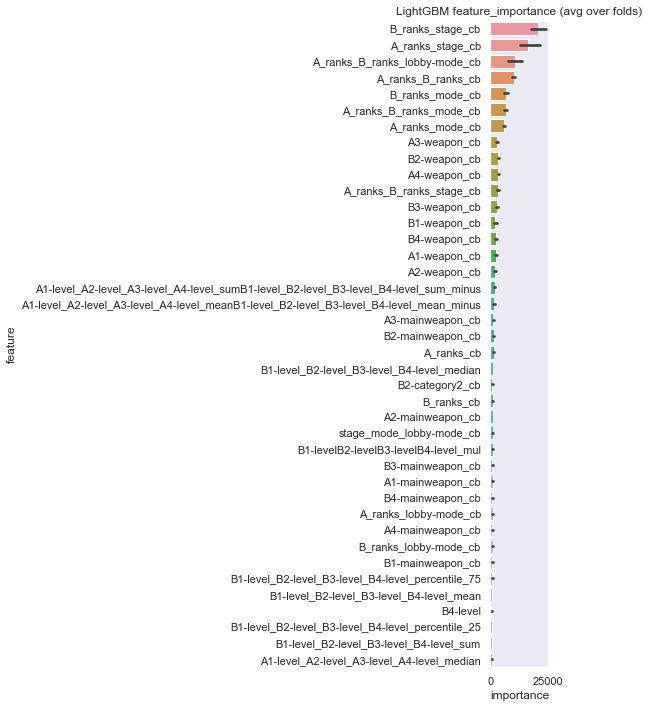

In [26]:
# old
df_all = pd.read_csv(f"{DATA_DIR}/eng2.csv", index_col=0)
base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": True})

# rfecv.csv

Starting LightGBM. Train shape: (66105, 149), test shape: (28340, 149)


0it [00:00, ?it/s]

run encoding Train shape: (59494, 253), valid shape: (6611, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.366188	training's binary_logloss: 0.66303	valid_1's binary_error: 0.456663	valid_1's binary_logloss: 0.685247
[400]	training's binary_error: 0.341009	training's binary_logloss: 0.643893	valid_1's binary_error: 0.452125	valid_1's binary_logloss: 0.684857
Early stopping, best iteration is:
[386]	training's binary_error: 0.341698	training's binary_logloss: 0.645396	valid_1's binary_error: 0.45273	valid_1's binary_logloss: 0.684507
Fold  1 error : 0.452730


1it [00:37, 37.42s/it]

run encoding Train shape: (59494, 253), valid shape: (6611, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.364121	training's binary_logloss: 0.662975	valid_1's binary_error: 0.453184	valid_1's binary_logloss: 0.685402
Early stopping, best iteration is:
[137]	training's binary_error: 0.38414	training's binary_logloss: 0.669637	valid_1's binary_error: 0.448949	valid_1's binary_logloss: 0.686278
Fold  2 error : 0.448949


2it [01:13, 37.15s/it]

run encoding Train shape: (59494, 253), valid shape: (6611, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.3676	training's binary_logloss: 0.662574	valid_1's binary_error: 0.467554	valid_1's binary_logloss: 0.686708
[400]	training's binary_error: 0.340404	training's binary_logloss: 0.643277	valid_1's binary_error: 0.461352	valid_1's binary_logloss: 0.687093
Early stopping, best iteration is:
[249]	training's binary_error: 0.357532	training's binary_logloss: 0.657443	valid_1's binary_error: 0.465739	valid_1's binary_logloss: 0.686386
Fold  3 error : 0.465739


3it [01:51, 37.15s/it]

run encoding Train shape: (59494, 253), valid shape: (6611, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.363398	training's binary_logloss: 0.662674	valid_1's binary_error: 0.456361	valid_1's binary_logloss: 0.685732
[400]	training's binary_error: 0.341244	training's binary_logloss: 0.643619	valid_1's binary_error: 0.456512	valid_1's binary_logloss: 0.685823
Early stopping, best iteration is:
[239]	training's binary_error: 0.357364	training's binary_logloss: 0.658387	valid_1's binary_error: 0.451066	valid_1's binary_logloss: 0.685288
Fold  4 error : 0.451066


4it [02:28, 37.23s/it]

run encoding Train shape: (59494, 253), valid shape: (6611, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.364995	training's binary_logloss: 0.662507	valid_1's binary_error: 0.460142	valid_1's binary_logloss: 0.687806
[400]	training's binary_error: 0.339446	training's binary_logloss: 0.643347	valid_1's binary_error: 0.459386	valid_1's binary_logloss: 0.688459
Early stopping, best iteration is:
[240]	training's binary_error: 0.357196	training's binary_logloss: 0.658148	valid_1's binary_error: 0.456814	valid_1's binary_logloss: 0.687508
Fold  5 error : 0.456814


5it [03:06, 37.48s/it]

run encoding Train shape: (59495, 253), valid shape: (6610, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.365258	training's binary_logloss: 0.662596	valid_1's binary_error: 0.448109	valid_1's binary_logloss: 0.684712
[400]	training's binary_error: 0.342466	training's binary_logloss: 0.643718	valid_1's binary_error: 0.447504	valid_1's binary_logloss: 0.68412
Early stopping, best iteration is:
[380]	training's binary_error: 0.343441	training's binary_logloss: 0.645541	valid_1's binary_error: 0.446445	valid_1's binary_logloss: 0.683837
Fold  6 error : 0.446445


6it [03:44, 37.71s/it]

run encoding Train shape: (59495, 253), valid shape: (6610, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.366031	training's binary_logloss: 0.66256	valid_1's binary_error: 0.461422	valid_1's binary_logloss: 0.686161
[400]	training's binary_error: 0.340751	training's binary_logloss: 0.643403	valid_1's binary_error: 0.462481	valid_1's binary_logloss: 0.686264
Early stopping, best iteration is:
[288]	training's binary_error: 0.350853	training's binary_logloss: 0.653462	valid_1's binary_error: 0.460212	valid_1's binary_logloss: 0.685696
Fold  7 error : 0.460212


7it [04:22, 37.71s/it]

run encoding Train shape: (59495, 253), valid shape: (6610, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.365997	training's binary_logloss: 0.662823	valid_1's binary_error: 0.461725	valid_1's binary_logloss: 0.685952
[400]	training's binary_error: 0.340718	training's binary_logloss: 0.643609	valid_1's binary_error: 0.458396	valid_1's binary_logloss: 0.685918
Early stopping, best iteration is:
[293]	training's binary_error: 0.350063	training's binary_logloss: 0.653148	valid_1's binary_error: 0.459002	valid_1's binary_logloss: 0.685339
Fold  8 error : 0.459002


8it [05:00, 37.84s/it]

run encoding Train shape: (59495, 253), valid shape: (6610, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.366401	training's binary_logloss: 0.662799	valid_1's binary_error: 0.45416	valid_1's binary_logloss: 0.685719
[400]	training's binary_error: 0.341978	training's binary_logloss: 0.643783	valid_1's binary_error: 0.451135	valid_1's binary_logloss: 0.685423
Early stopping, best iteration is:
[248]	training's binary_error: 0.355845	training's binary_logloss: 0.657788	valid_1's binary_error: 0.449773	valid_1's binary_logloss: 0.685203
Fold  9 error : 0.449773


9it [05:38, 37.79s/it]

run encoding Train shape: (59495, 253), valid shape: (6610, 253)
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.367157	training's binary_logloss: 0.662677	valid_1's binary_error: 0.449168	valid_1's binary_logloss: 0.685215
[400]	training's binary_error: 0.34144	training's binary_logloss: 0.642798	valid_1's binary_error: 0.444327	valid_1's binary_logloss: 0.685005
Early stopping, best iteration is:
[317]	training's binary_error: 0.348181	training's binary_logloss: 0.650028	valid_1's binary_error: 0.446293	valid_1's binary_logloss: 0.684548
Fold 10 error : 0.446293


10it [06:16, 37.61s/it]


Full error score 0.453702


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


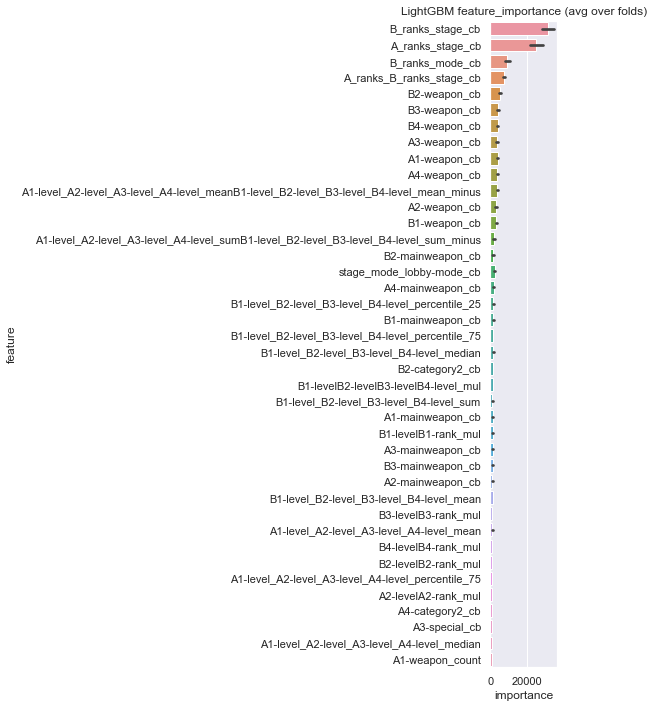

In [11]:
df_all = pd.read_csv(f"{DATA_DIR}/eng2.csv", index_col=0)

rfecv_cols = pd.read_csv(f"{DATA_DIR}/rfecv_select_cols.csv")["select_cols"].values
#rfecv_cols = pd.read_csv(f"{DATA_DIR}/rfecv.csv").columns.to_list()
df_all = df_all[rfecv_cols]

base_train(df_all, dict_enc_flag={"count": True, "target": False, "catboost": True})

# feature_selection_cols.csv

Starting LightGBM. Train shape: (66105, 275), test shape: (28340, 275)







0it [00:00, ?it/s]

run encoding Train shape: (59494, 551), valid shape: (6611, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.3755	training's binary_logloss: 0.652755	valid_1's binary_error: 0.457873	valid_1's binary_logloss: 0.689024
Early stopping, best iteration is:
[163]	training's binary_error: 0.380778	training's binary_logloss: 0.657883	valid_1's binary_error: 0.459688	valid_1's binary_logloss: 0.688228
Fold  1 error : 0.459688







1it [02:13, 134.00s/it]

run encoding Train shape: (59494, 551), valid shape: (6611, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.371987	training's binary_logloss: 0.65282	valid_1's binary_error: 0.461957	valid_1's binary_logloss: 0.689016
Early stopping, best iteration is:
[83]	training's binary_error: 0.411857	training's binary_logloss: 0.671656	valid_1's binary_error: 0.460596	valid_1's binary_logloss: 0.687976
Fold  2 error : 0.460596







2it [04:27, 133.75s/it]

run encoding Train shape: (59494, 551), valid shape: (6611, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.376088	training's binary_logloss: 0.652541	valid_1's binary_error: 0.466344	valid_1's binary_logloss: 0.688737
Early stopping, best iteration is:
[165]	training's binary_error: 0.381954	training's binary_logloss: 0.657401	valid_1's binary_error: 0.471033	valid_1's binary_logloss: 0.688311
Fold  3 error : 0.471033







3it [06:39, 133.47s/it]

run encoding Train shape: (59494, 551), valid shape: (6611, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.374223	training's binary_logloss: 0.652681	valid_1's binary_error: 0.460899	valid_1's binary_logloss: 0.689123
Early stopping, best iteration is:
[112]	training's binary_error: 0.399015	training's binary_logloss: 0.665779	valid_1's binary_error: 0.459386	valid_1's binary_logloss: 0.688287
Fold  4 error : 0.459386







4it [08:52, 133.31s/it]

run encoding Train shape: (59494, 551), valid shape: (6611, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.376072	training's binary_logloss: 0.652394	valid_1's binary_error: 0.464529	valid_1's binary_logloss: 0.691681
Early stopping, best iteration is:
[83]	training's binary_error: 0.414496	training's binary_logloss: 0.671312	valid_1's binary_error: 0.477991	valid_1's binary_logloss: 0.689798
Fold  5 error : 0.477991







5it [11:06, 133.49s/it]

run encoding Train shape: (59495, 551), valid shape: (6610, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.376216	training's binary_logloss: 0.652883	valid_1's binary_error: 0.45053	valid_1's binary_logloss: 0.68732
Early stopping, best iteration is:
[173]	training's binary_error: 0.379007	training's binary_logloss: 0.656645	valid_1's binary_error: 0.451286	valid_1's binary_logloss: 0.6868
Fold  6 error : 0.451286







6it [13:19, 133.14s/it]

run encoding Train shape: (59495, 551), valid shape: (6610, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.373174	training's binary_logloss: 0.652532	valid_1's binary_error: 0.473979	valid_1's binary_logloss: 0.690106
Early stopping, best iteration is:
[85]	training's binary_error: 0.414186	training's binary_logloss: 0.670916	valid_1's binary_error: 0.476551	valid_1's binary_logloss: 0.689148
Fold  7 error : 0.476551







7it [15:30, 132.58s/it]

run encoding Train shape: (59495, 551), valid shape: (6610, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.37346	training's binary_logloss: 0.652831	valid_1's binary_error: 0.45885	valid_1's binary_logloss: 0.687798
Early stopping, best iteration is:
[163]	training's binary_error: 0.379023	training's binary_logloss: 0.657943	valid_1's binary_error: 0.465204	valid_1's binary_logloss: 0.687431
Fold  8 error : 0.465204







8it [17:43, 132.69s/it]

run encoding Train shape: (59495, 551), valid shape: (6610, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.37462	training's binary_logloss: 0.652744	valid_1's binary_error: 0.460817	valid_1's binary_logloss: 0.688507
Early stopping, best iteration is:
[152]	training's binary_error: 0.384772	training's binary_logloss: 0.65933	valid_1's binary_error: 0.456581	valid_1's binary_logloss: 0.68808
Fold  9 error : 0.456581







9it [19:57, 133.18s/it]

run encoding Train shape: (59495, 551), valid shape: (6610, 551)
len(feats): 299
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.375729	training's binary_logloss: 0.654471	valid_1's binary_error: 0.453707	valid_1's binary_logloss: 0.68895
Early stopping, best iteration is:
[168]	training's binary_error: 0.382301	training's binary_logloss: 0.659516	valid_1's binary_error: 0.455825	valid_1's binary_logloss: 0.688359
Fold 10 error : 0.455825







10it [22:15, 133.57s/it]


Full error score 0.463414


C:\Users\81908\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


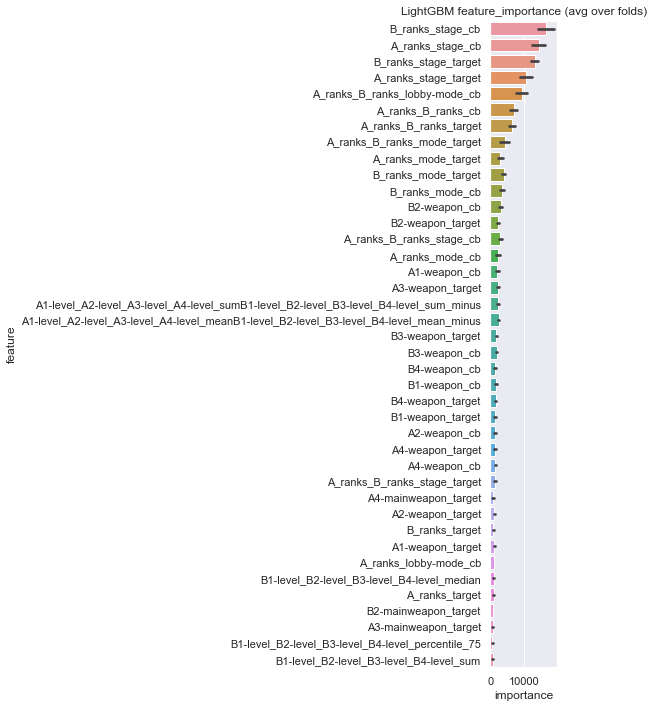

In [23]:
def train_select_cols(df, dict_enc_flag={"count": True, "target": True, "catboost": True}, out_dir=OUT_MODEL):
    is_debug = False
    # is_debug = True
    if is_debug:
        _df = df.head(1000)
        _df = _df.append(df.tail(100))
        df = _df

    best_params = {'subsample': 0.9, 'subsample_freq': 6, 'colsample_bytree': 0.1, 'max_depth': 7, 'min_child_samples': 343, 'min_child_weight': 0.04084861948055769, 'num_leaves': 95, 'reg_alpha': 0.5612212694825488, 'reg_lambda': 0.0001757886119766502}
        
    os.makedirs(out_dir, exist_ok=True)
    model = Model(out_dir, dict_enc_flag)
    lgb_params = dict(
        n_estimators=10000,
        learning_rate=0.01,
        silent=-1,
        #verbose=-1,
        # verbose=1,
        importance_type="gain",
        random_state=71,
        **best_params,
    )
    params = dict(
        lgb_params=lgb_params,
        df=df,
        num_folds=10,
        #num_folds=4,
        target_col="y",
        del_cols=None,
        select_cols=pd.read_csv(f"{DATA_DIR}/feature_selection_cols.csv")["feature_selections"].to_list(),
        eval_metric="error",
        #stratified=True,
        stratified=False,
        is_submission=True,
        is_plot_perm_importance=False,
    )
    feat_importance, perm_importance = model.kfold_cv_LGBMClassifier(**params)
    
df_all = pd.read_csv(f"{DATA_DIR}/eng2.csv", index_col=0)
train_select_cols(df_all)

# パラメータチューニングしてモデル作成

In [ ]:
import os
import numpy as np
import pandas as pd
import gc
from joblib import Parallel, delayed
import lightgbm as lgb
import optuna
from sklearn.feature_selection import RFECV
from sklearn.model_selection import *
from sklearn.metrics import *
import seaborn as sns

def exec_study(X, y, cv_index_kv, n_trials, output_dir, t_args):
    def objective(trial):
        gc.collect()
        # ハイパーパラメータ
        max_depth = trial.suggest_int("max_depth", 1, 8)
        num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
        min_child_samples = trial.suggest_int(
            "min_child_samples", 1, max(1, int(len(cv_index_kv[1][0]) / num_leaves)))
        tuning_params = dict(
            max_depth=max_depth,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            min_child_weight=trial.suggest_loguniform('min_child_weight', 0.001, 1000),
            feature_fraction=trial.suggest_discrete_uniform('colsample_bytree', 0.1, 0.95, 0.05),  # feature_fractionのこと
            bagging_fraction=trial.suggest_discrete_uniform('subsample', 0.4, 0.95, 0.05),  # bagging_fractionのこと
            bagging_freq=trial.suggest_int('subsample_freq', 1, 10),  # bagging_freqのこと
            reg_alpha=trial.suggest_loguniform('reg_alpha', 1e-09, 10.0),
            reg_lambda=trial.suggest_loguniform('reg_lambda', 1e-09, 10.0),
        )
        if t_args['objective'] == "regression":
            tuning_params["reg_sqrt"] = trial.suggest_categorical("reg_sqrt", [True, False])
        print(tuning_params)

        # クロスバリデーション
        def calc_score(train_index, val_index):
            train_df = pd.concat([X, y], axis=1)
            t_fold_df = train_df.iloc[train_index]
            v_fold_df = train_df.iloc[val_index]
            # カウントエンコディング
            t_fold_df, v_fold_df = count_encoder(
                t_fold_df, v_fold_df, cat_features=None
            )
            # ターゲットエンコディング
            t_fold_df, v_fold_df = target_encoder(
                t_fold_df, v_fold_df, target_col=target_col, cat_features=None
            )
            # CatBoostエンコディング
            t_fold_df, v_fold_df = catboost_encoder(
                t_fold_df, v_fold_df, target_col=target_col, cat_features=None
            )
            # ラベルエンコディング
            cate_cols = t_fold_df.select_dtypes(
                include=["object", "category", "bool"]
            ).columns.to_list()
            for col in cate_cols:
                t_fold_df[col], uni = pd.factorize(t_fold_df[col])
                v_fold_df[col], uni = pd.factorize(v_fold_df[col])
            print(
                "run encoding Train shape: {}, valid shape: {}".format(
                    t_fold_df.shape, v_fold_df.shape
                )
            )
            feats = t_fold_df.columns.to_list()
            feats.remove(target_col)
            X_train, y_train = (
                t_fold_df[feats],
                t_fold_df[target_col],
            )
            X_val, y_val = (
                v_fold_df[feats],
                v_fold_df[target_col],
            )
            
            #X_train = X.iloc[train_index]  # TODO df,using_cols,gkfはグローバル変数にしないといけない？
            #y_train = y.iloc[train_index]
            #X_val   = X.iloc[val_index]
            #y_val   = y.iloc[val_index]
            if t_args['objective'] == "regression":
                #model = lgb.LGBMRegressor(n_jobs=1, seed=71, n_estimators=10000, learning_rate=0.1, verbose=-1, **tuning_params)
                model = lgb.LGBMRegressor(n_jobs=-1, seed=71, n_estimators=10000, learning_rate=0.1, verbose=-1, **tuning_params)
            else:
                #model = lgb.LGBMClassifier(n_jobs=1, seed=71, n_estimators=10000, learning_rate=0.1, verbose=-1, **tuning_params)
                model = lgb.LGBMClassifier(n_jobs=-1, seed=71, n_estimators=10000, learning_rate=0.1, verbose=-1, **tuning_params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, eval_metric=t_args['eval_metric'], verbose=False)
            
            if t_args["objective"] == "regression":
                score = mean_squared_error(y_val, model.predict(X_val))
            else:
                #score = 1.0 - roc_auc_score(y_val, model.predict(X_val))
                score = 1.0 - accuracy_score(y_val, model.predict(X_val))
            return score
        
        #scores = Parallel(n_jobs=-1)([delayed(calc_score)(train_index, valid_index) for train_index, valid_index in cv_index_kv])
        scores = []
        for train_index, valid_index in cv_index_kv:
            scores = calc_score(train_index, valid_index)
        return np.mean(scores)

    # 学習実行
    study = optuna.create_study(study_name="study",
                                storage=f"sqlite:///{output_dir}/study.db",
                                load_if_exists=True,
                                direction="minimize", 
                                sampler=optuna.samplers.TPESampler(seed=1))
    study.optimize(objective, n_trials=n_trials, n_jobs=1, gc_after_trial=True)
    
    # 学習履歴保存
    study.trials_dataframe().to_csv(f"{output_dir}/study_history.csv", index=False)
    
    # 最適化されたハイパーパラメータ
    return study.best_params.copy()

if __name__ == '__main__':  
    df_all = pd.read_csv(f"{WORK_DIR}/eda_preprocess.csv", index_col=0)
    # df_all = pd.read_csv(f"{OUT_DATA}/feature_add.csv")
    # cols = pd.read_csv(f"{OUT_DATA}/feature_selections.csv")["feature_selections"].values.tolist()
    target_col = "y"
    #cols.append(target_col)
    #df = df_all[cols]
    df = df_all   
    print(df.shape)
    
    train = df[df[target_col].notnull()].reset_index(drop=True)
    test = df[df[target_col].isnull()].reset_index(drop=True)
    y_col = "y"
    using_cols = df.columns.to_list()
    using_cols = list(set(using_cols) - set([y_col]))
    
    n_trials = 300
    
    output_dir = OUT_MODEL
    os.makedirs(output_dir, exist_ok=True)
    
    t_args = dict(objective="binary",
                  eval_metric="binary_logloss",
                  #objective="regression",
                  #eval_metric="rmse",
                 )
    
    X_train = df.loc[train.index][using_cols]
    y_train = df.loc[train.index][y_col]
    n_fold = 4
    cv_index_kv = list(KFold(n_fold).split(X_train, y_train))
    #cv_index_kv = list(StratifiedKFold(n_fold).split(X_train, y_train))
    
    # 学習実行
    best_params = exec_study(X_train, y_train, cv_index_kv, n_trials, output_dir, t_args)
    print("best_params:\n", best_params)
    best_params_df = pd.DataFrame(best_params.values(), index=best_params.keys()) 
    best_params_df.to_csv(f"{output_dir}/best_params.tsv", sep="\t")

In [13]:
import sys

sys.path.append(r"C:\Users\81908\Git\OptGBM")
import optgbm as lgb


class Model:
    def __init__(self, OUTPUT_DIR, dict_enc_flag={"count": True, "target": True, "catboost": True}):
        self.OUTPUT_DIR = OUTPUT_DIR
        self.dict_enc_flag = dict_enc_flag

    # LightGBM GBDT with KFold or Stratified KFold
    # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
    def kfold_cv_LGBMClassifier(
        self,
        lgb_params: dict,
        df: pd.DataFrame,
        num_folds: int,
        target_col: str,
        del_cols=None,
        eval_metric="error",
        stratified=True,  # StratifiedKFoldにするか
        is_submission=False,  # Home_Credit_Default_Risk の submission.csv作成するか
        is_plot_perm_importance=False,  # permutation importanceも出すか. feature_importance はデフォルトでだす
    ):
        """
        LGBMClassifierでcross validation + feature_importance/permutation importance plot
        """
        # Divide in training/validation and test data
        train_df = df[df[target_col].notnull()].reset_index(drop=True)
        test_df = df[df[target_col].isnull()].reset_index(drop=True)
        print(
            "Starting LightGBM. Train shape: {}, test shape: {}".format(
                train_df.shape, test_df.shape
            )
        )
        del df
        gc.collect()

        # Cross validation model
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

        # Create arrays and dataframes to store results
        oof_preds = np.zeros(train_df.shape[0])
        sub_preds = np.zeros(test_df.shape[0])
        feature_importance_df = pd.DataFrame()
        permutation_importance_df = pd.DataFrame()
        result_scores = {}
        train_probas = {}
        test_probas = {}

        # 目的変数とID列など削除
        del_cols = del_cols.append(target_col) if del_cols is not None else [target_col]
        feats = [f for f in train_df.columns if f not in del_cols]

        for n_fold, (train_idx, valid_idx) in tqdm(
            enumerate(folds.split(train_df[feats], train_df[target_col]))
        ):
            t_fold_df = train_df.iloc[train_idx]
            v_fold_df = train_df.iloc[valid_idx]

            if self.dict_enc_flag["count"]:
                # カウントエンコディング
                t_fold_df, v_fold_df = count_encoder(
                    t_fold_df, v_fold_df, cat_features=None
                )
            if self.dict_enc_flag["target"]:
                # ターゲットエンコディング
                t_fold_df, v_fold_df = target_encoder(
                    t_fold_df, v_fold_df, target_col=target_col, cat_features=None
                )
            if self.dict_enc_flag["catboost"]:
                # CatBoostエンコディング
                t_fold_df, v_fold_df = catboost_encoder(
                    t_fold_df, v_fold_df, target_col=target_col, cat_features=None
                )
            # ラベルエンコディング
            cate_cols = t_fold_df.select_dtypes(
                include=["object", "category", "bool"]
            ).columns.to_list()
            for col in cate_cols:
                t_fold_df[col], uni = pd.factorize(t_fold_df[col])
                v_fold_df[col], uni = pd.factorize(v_fold_df[col])
            print(
                "run encoding Train shape: {}, valid shape: {}".format(
                    t_fold_df.shape, v_fold_df.shape
                )
            )

            feats = t_fold_df.columns.to_list()
            feats.remove(target_col)

            train_x, train_y = (
                t_fold_df[feats],
                t_fold_df[target_col],
            )
            valid_x, valid_y = (
                v_fold_df[feats],
                v_fold_df[target_col],
            )

            ############################ train fit ############################
            # LightGBM parameters found by Bayesian optimization
            clf = lgb.LGBMClassifier(**lgb_params)
            clf.fit(
                train_x,
                train_y,
                # eval_set=[(train_x, train_y), (valid_x, valid_y)],
                # eval_metric=eval_metric,
                # verbose=200,
                # early_stopping_rounds=200,
            )

            # モデル保存
            joblib.dump(clf, f"{self.OUTPUT_DIR}/lgb-{n_fold + 1}.model", compress=True)

            # valid pred
            oof_preds[valid_idx] = clf.predict_proba(
                valid_x, num_iteration=clf.best_iteration_
            )[:, 1]

            ############################ test pred ############################
            if self.dict_enc_flag["count"]:
                # カウントエンコディング
                tr_df, te_df = count_encoder(train_df, test_df, cat_features=None)
            else:
                tr_df, te_df = train_df, test_df
            if self.dict_enc_flag["target"]:
                # ターゲットエンコディング
                tr_df, te_df = target_encoder(tr_df, te_df, target_col=target_col, cat_features=None)
            else:
                tr_df, te_df = tr_df, te_df
            if self.dict_enc_flag["catboost"]:
                # CatBoostエンコディング
                tr_df, te_df = catboost_encoder(tr_df, te_df, target_col=target_col, cat_features=None)
            else:
                tr_df, te_df = tr_df, te_df
            # ラベルエンコディング
            cate_cols = tr_df.select_dtypes(
                include=["object", "category", "bool"]
            ).columns.to_list()
            for col in cate_cols:
                tr_df[col], uni = pd.factorize(tr_df[col])
                te_df[col], uni = pd.factorize(te_df[col])
                
            # testの確信度
            test_probas[f"fold_{str(n_fold + 1)}"] = clf.predict_proba(
                te_df[feats], num_iteration=clf.best_iteration_
            )[:, 1]
            sub_preds += test_probas[f"fold_{str(n_fold + 1)}"] / folds.n_splits

            # 一応trainの確信度も出しておく
            train_probas[f"fold_{str(n_fold + 1)}"] = clf.predict_proba(
                tr_df[feats], num_iteration=clf.best_iteration_
            )[:, 1]

            if eval_metric == "auc":
                fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
                print("Fold %2d AUC : %.6f" % (n_fold + 1, fold_auc))
                result_scores[f"fold_auc_{str(n_fold + 1)}"] = fold_auc
            elif eval_metric == "error":
                # intにしないとaccuracy_score()エラーになる
                _pred = oof_preds[valid_idx]
                _pred[_pred >= 0.5] = 1
                _pred[_pred < 0.5] = 0
                fold_err = 1.0 - accuracy_score(valid_y, _pred)
                print("Fold %2d error : %.6f" % (n_fold + 1, fold_err))
                result_scores[f"fold_err_{str(n_fold + 1)}"] = fold_err

            # feature_importance
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat(
                [feature_importance_df, fold_importance_df], axis=0
            )

            if is_plot_perm_importance:
                # permutation_importance
                # 時間かかるからifで制御する
                # scoringはsklearnのスコアリングパラメータ
                # accuracy や neg_mean_squared_log_error とか
                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                fold_importance_df = pd.DataFrame()
                fold_permutation = permutation_importance(
                    clf, valid_x, valid_y, scoring="roc_auc"
                )
                fold_permutation_df = pd.DataFrame(
                    {
                        "feature": valid_x.columns,
                        "importance": np.abs(
                            fold_permutation["importances_mean"]
                        ),  # マイナスとるのもあるので絶対値にする
                        "fold": n_fold + 1,
                    },
                )
                permutation_importance_df = pd.concat(
                    [permutation_importance_df, fold_permutation_df], axis=0
                )

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        if eval_metric == "auc":
            mean_fold_auc = roc_auc_score(train_df[target_col], oof_preds)
            print("Full AUC score %.6f" % mean_fold_auc)
            result_scores["mean_fold_auc"] = mean_fold_auc
        elif eval_metric == "error":
            # intにしないとaccuracy_score()エラーになる
            _pred = oof_preds
            _pred[_pred >= 0.5] = 1
            _pred[_pred < 0.5] = 0
            mean_fold_err = 1.0 - accuracy_score(train_df[target_col], _pred)
            print("Full error score %.6f" % mean_fold_err)
            result_scores["mean_fold_err"] = mean_fold_err

        # モデルのスコア出力
        result_scores_df = pd.DataFrame(
            result_scores.values(), index=result_scores.keys()
        )
        result_scores_df.to_csv(f"{self.OUTPUT_DIR}/result_scores.tsv", sep="\t")

        test_probas_df = pd.DataFrame(test_probas)
        test_probas_df.to_csv(f"{self.OUTPUT_DIR}/test_probas.tsv", index=False)
        train_probas_df = pd.DataFrame(train_probas)
        train_probas_df.to_csv(f"{self.OUTPUT_DIR}/train_probas.tsv", index=False)

        # Write submission file (Home_Credit_Default_Risk)
        if is_submission:
            sub_preds[sub_preds >= 0.5] = 1
            sub_preds[sub_preds < 0.5] = 0
            test_df[target_col] = sub_preds
            submission_file_name = f"{self.OUTPUT_DIR}/submission_kernel.csv"
            sub_df = test_df[[target_col]]
            sub_df["id"] = test_df.index
            sub_df.astype(int)
            sub_df = sub_df[["id", "y"]]
            sub_df.to_csv(submission_file_name, index=False)

        # Plot feature importance
        Model("").display_importances(
            feature_importance_df,
            png_path=f"{self.OUTPUT_DIR}/lgbm_feature_importances.png",
            title="feature_importance",
        )
        if is_plot_perm_importance:
            Model("").display_importances(
                permutation_importance_df,
                png_path=f"{self.OUTPUT_DIR}/lgbm_permutation_importances.png",
                title="permutation_importance",
            )

        return feature_importance_df, permutation_importance_df

    # Display/plot feature/permutation importance
    @staticmethod
    def display_importances(
        importance_df_, png_path, title,
    ):
        cols = (
            importance_df_[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:40]
            .index
        )
        best_features = importance_df_.loc[importance_df_.feature.isin(cols)]
        plt.figure(figsize=(8, 10))
        sns.barplot(
            x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False),
        )
        plt.title(f"LightGBM {title} (avg over folds)")
        plt.tight_layout()
        plt.savefig(png_path)
        
        
if __name__ == "__main__":
    df = df_all

    is_debug = False
    #is_debug = True
    if is_debug:
        _df = df.head(1000)
        _df = _df.append(df.tail(100))
        df = _df

    model = Model(OUT_MODEL)
    lgb_params = dict(
        n_estimators=10000,
        learning_rate=0.01,
        silent=-1,
        verbose=-1,
        # verbose=1,
        random_state=71,
        importance_type="gain",
    )
    params = dict(
        lgb_params=lgb_params,
        df=df,
        num_folds=10,
        target_col="y",
        del_cols=None,
        eval_metric="error",
        stratified=True,
        is_submission=True,
        is_plot_perm_importance=False,
    )
    feat_importance, perm_importance = model.kfold_cv_LGBMClassifier(**params)

Starting LightGBM. Train shape: (66105, 149), test shape: (28340, 149)



0it [00:00, ?it/s]

run encoding Train shape: (59494, 305), valid shape: (6611, 305)


Searching the best hyperparameters...
[I 2020-08-27 20:48:42,919] Finished trial#0 with value: 0.652638914683701 with parameters: {'feature_fraction': 0.25, 'max_depth': 4, 'num_leaves': 9, 'min_data_in_leaf': 1577, 'lambda_l1': 0.013464069611556016, 'lambda_l2': 4.957785614047395e-08, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7}. Best is trial#0 with value: 0.652638914683701.
[I 2020-08-27 20:49:01,651] Finished trial#1 with value: 0.644784122368256 with parameters: {'feature_fraction': 0.75, 'max_depth': 7, 'num_leaves': 53, 'min_data_in_leaf': 384, 'lambda_l1': 1.342787583539349, 'lambda_l2': 0.0001394614878544168, 'bagging_fraction': 0.5, 'bagging_freq': 2}. Best is trial#1 with value: 0.644784122368256.
[I 2020-08-27 20:49:19,892] Finished trial#2 with value: 0.640294340850595 with parameters: {'feature_fraction': 0.65, 'max_depth': 6, 'num_leaves': 48, 'min_data_in_leaf': 177, 'lambda_l1': 6.376795976584898e-09, 'lambda_l2': 4.453354828083046e-06, 'bagging_fraction'

Fold  1 error : 0.460142



1it [11:52, 712.05s/it]

run encoding Train shape: (59494, 305), valid shape: (6611, 305)


Searching the best hyperparameters...
[I 2020-08-27 21:00:34,491] Finished trial#0 with value: 0.6530336793194825 with parameters: {'feature_fraction': 0.25, 'max_depth': 4, 'num_leaves': 9, 'min_data_in_leaf': 1577, 'lambda_l1': 0.013464069611556016, 'lambda_l2': 4.957785614047395e-08, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7}. Best is trial#0 with value: 0.6530336793194825.
[I 2020-08-27 21:00:47,660] Finished trial#1 with value: 0.6465623865396827 with parameters: {'feature_fraction': 0.75, 'max_depth': 7, 'num_leaves': 53, 'min_data_in_leaf': 384, 'lambda_l1': 1.342787583539349, 'lambda_l2': 0.0001394614878544168, 'bagging_fraction': 0.5, 'bagging_freq': 2}. Best is trial#1 with value: 0.6465623865396827.
[I 2020-08-27 21:00:59,272] Finished trial#2 with value: 0.6461573421809292 with parameters: {'feature_fraction': 0.65, 'max_depth': 6, 'num_leaves': 48, 'min_data_in_leaf': 177, 'lambda_l1': 6.376795976584898e-09, 'lambda_l2': 4.453354828083046e-06, 'bagging_frac

KeyboardInterrupt: 